In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import optuna
import tqdm as notebook_tqdm
import scipy
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler, Normalizer, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import kruskal
from lazypredict.Supervised import LazyRegressor
from catboost import CatBoostRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, HuberRegressor, ElasticNet, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, IsolationForest, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score \
,GridSearchCV, KFold, RepeatedKFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit \
, RandomizedSearchCV, cross_val_predict


# DISPLAY ALL COLUMNS DATASET DATAFRAME
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

# Define the problem and analyze it from a broader perspective

## 1. Define the objective in business terms

The goal of the project is to develop a machine learning model for predicting real estate prices, which will enable more accurate and faster estimation of the value of apartments and houses.

## 2. Describe how your solution will be used
My solution will be used as a real estate price prediction system and can be implemented in several forms, such as:

* a web application
* an API
* an analytical dashboard
* a reporting module
* integration with mobile applications

## 3. Identify existing solutions or workarounds (if any)
#### Traditional valuation methods:

* Manual appraisal by a property valuer
* Comparative method
* Income method

---

#### Existing technological solutions:

* Automated Valuation Models (AVMs)
* Real estate listing portals with price analysis
* AI-based tools in real estate

## 4. In which categories should the problem be defined (unsupervised/supervised, incremental/static, etc.)?

* **Learning:** supervised
* **Prediction type:** regression
* **Learning mode:** initially static, later incremental
* **Type of data:** tabular, optionally temporal and geospatial

## 5. How will the model's performance be measured?

The results are evaluated based on the Root Mean Squared Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale price. (The use of logarithms means that errors in predicting expensive and inexpensive houses will have the same impact on the score).

## 6. Is the performance measurement linked to the business objective?

The business objective is to develop a model that accurately predicts real estate prices, supporting agencies, investors, and buyers in decision-making.
RMSE measures the model’s accuracy in the same units as property prices (e.g., in USD), which makes it intuitive to interpret.
A lower RMSE indicates better model precision, leading to more reliable valuations and improved business decisions.

## 7. What is the minimum performance required to meet the business objective?

RMSE (Root Mean Squared Error) ≤ 20,000 (preferably below 15,000)

## 8. Are there any comparable problems? Can you leverage existing experience or tools?

Yes, there are many comparable problems that can provide valuable experience and tools for solving the real estate price prediction problem, such as stock price prediction, energy price forecasting, credit risk assessment, and demand prediction for services.

#### Tools:

* **Scikit-learn:** A tool for building classic ML models such as linear regression, XGBoost, and Random Forest.

## 9. Can you get help from experts?
No

## 10. How can the problem be solved manually?
Solving the real estate price prediction problem manually would require an approach based on manually collecting and analyzing data, drawing conclusions from experience, and making decisions intuitively.

## 11. Make a list of assumptions established by you (or others)
#### Assumptions regarding the data:

* **Availability of historical data:** It is assumed that there is a sufficient amount of historical data on real estate prices, such as sales transactions, location data, floor area, property type, technical condition, etc.
* **High data quality:** It is assumed that the data does not contain significant gaps, errors, or anomalies. In case of missing values, it is assumed they can be filled using interpolation, medians, or other imputation techniques.
* **Consistency of units:** All data is measured in consistent units (e.g., area in square meters, prices in local currency).

---

#### **Assumptions regarding the model:**

* **Regression model:** It is assumed that the model for predicting real estate prices will be a regression model, as the goal is to predict a numerical value (price).
* **Model simplicity at the beginning:** Initially, simpler models will be used (e.g., linear regression, decision trees) as a baseline. If they prove insufficient, more advanced methods such as XGBoost or neural networks will be applied later.
* **Model stability:** The model is expected to provide sufficient stability and accuracy on new, unseen data, which requires applying proper validation techniques.

---

#### **Assumptions regarding model usage:**

* **Availability of current input data:** The model will operate in real time, assuming that system users (e.g., real estate agents) will provide up-to-date input data (e.g., new property listings).
* **User education:** System users (e.g., investors, real estate agents) will be properly trained in interpreting the model’s results and applying them in decision-making.

---

#### **Assumptions regarding model performance:**

* **Expected accuracy level:** It is assumed that the model will achieve accuracy acceptable in the business context, i.e., RMSE ≤ 20,000.
* **Expected speed of operation:** The model should be fast enough to be used in real time (e.g., for quick property valuation in response to a client’s inquiry).
* **Regular model updates:** The model will require regular retraining on new data to adapt to the changing real estate market.


# Data acquisition

## 1. Specify the type and amount of data needed
The provided data is in CSV format and contains 1,460 rows and 81 columns.

## 2. Identify the source from which you can obtain the data and document it
https://www.kaggle.com/competitions/home-data-for-ml-course/data

## 3. Check how much storage space will be needed to store the data
The data requires less than 1 MB of disk space.

## 4. Acquire the data and convert it into a format that allows easy manipulation (without changing the essence of the data), and ensure that sensitive data has been removed or secured (e.g., masked).

In [41]:
df_train = pd.read_csv('./data/train.csv')
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.00     8450   Pave   NaN      Reg   
1   2          20       RL        80.00     9600   Pave   NaN      Reg   
2   3          60       RL        68.00    11250   Pave   NaN      IR1   
3   4          70       RL        60.00     9550   Pave   NaN      IR1   
4   5          60       RL        84.00    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0      196.00        Gd        TA      PConc       Gd       TA           No   
1        0.00        TA        TA     CBlock       Gd       TA           Gd   
2      162.00        Gd        TA      PConc       Gd       TA           Mn   
3        0.00        TA        TA     BrkTil       TA       Gd           No   
4      350.00        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [42]:
df_train.iloc[0].values

array([np.int64(1), np.int64(60), 'RL', np.float64(65.0), np.int64(8450),
       'Pave', nan, 'Reg', 'Lvl', 'AllPub', 'Inside', 'Gtl', 'CollgCr',
       'Norm', 'Norm', '1Fam', '2Story', np.int64(7), np.int64(5),
       np.int64(2003), np.int64(2003), 'Gable', 'CompShg', 'VinylSd',
       'VinylSd', 'BrkFace', np.float64(196.0), 'Gd', 'TA', 'PConc', 'Gd',
       'TA', 'No', 'GLQ', np.int64(706), 'Unf', np.int64(0),
       np.int64(150), np.int64(856), 'GasA', 'Ex', 'Y', 'SBrkr',
       np.int64(856), np.int64(854), np.int64(0), np.int64(1710),
       np.int64(1), np.int64(0), np.int64(2), np.int64(1), np.int64(3),
       np.int64(1), 'Gd', np.int64(8), 'Typ', np.int64(0), nan, 'Attchd',
       np.float64(2003.0), 'RFn', np.int64(2), np.int64(548), 'TA', 'TA',
       'Y', np.int64(0), np.int64(61), np.int64(0), np.int64(0),
       np.int64(0), np.int64(0), nan, nan, nan, np.int64(0), np.int64(2),
       np.int64(2008), 'WD', 'Normal', np.int64(208500)], dtype=object)

## 5. Check the size and type of the data

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 6. Split the test set

In [44]:
df_test = pd.read_csv('./data/test.csv')
df_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH        80.00    11622   Pave   NaN      Reg   
1  1462          20       RL        81.00    14267   Pave   NaN      IR1   
2  1463          60       RL        74.00    13830   Pave   NaN      IR1   
3  1464          60       RL        78.00     9978   Pave   NaN      IR1   
4  1465         120       RL        43.00     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd        NaN   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd        NaN   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard        NaN   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0        0.00        TA        TA     CBlock       TA       TA           No   
1      108.00        TA        TA     CBlock       TA       TA           No   
2        0.00        TA        TA      PConc       Gd       TA           No   
3       20.00        TA        TA      PConc       TA       TA           No   
4        0.00        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec      468.00          LwQ      144.00     270.00       882.00   
1          ALQ      923.00          Unf        0.00     406.00      1329.00   
2          GLQ      791.00          Unf        0.00     137.00       928.00   
3          GLQ      602.00          Unf        0.00     324.00       926.00   
4          ALQ      263.00          Unf        0.00    1017.00      1280.00   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896          0.00          0.00         1         0             2   
1       1329          0.00          0.00         1         1             3   
2       1629          0.00          0.00         2         1             3   
3       1604          0.00          0.00         2         1             3   
4       1280          0.00          0.00         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

## 7. Combine both sets

In [45]:
combined_data = pd.concat((df_train,df_test), axis=0)
combined_data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.00     8450   Pave   NaN      Reg   
1   2          20       RL        80.00     9600   Pave   NaN      Reg   
2   3          60       RL        68.00    11250   Pave   NaN      IR1   
3   4          70       RL        60.00     9550   Pave   NaN      IR1   
4   5          60       RL        84.00    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0      196.00        Gd        TA      PConc       Gd       TA           No   
1        0.00        TA        TA     CBlock       Gd       TA           Gd   
2      162.00        Gd        TA      PConc       Gd       TA           Mn   
3        0.00        TA        TA     BrkTil       TA       Gd           No   
4      350.00        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ      706.00          Unf        0.00     150.00       856.00   
1          ALQ      978.00          Unf        0.00     284.00      1262.00   
2          GLQ      486.00          Unf        0.00     434.00       920.00   
3          ALQ      216.00          Unf        0.00     540.00       756.00   
4          GLQ      655.00          Unf        0.00     490.00      1145.00   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710          1.00          0.00         2         1             3   
1       1262          0.00          1.00         2         0             3   
2       1786          1.00          0.00         2         1             3   
3       1717          1.00          0.00         1         0             3   
4       2198          1.00          0.00         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

# Data analysis

## 1. Create a copy of the data being analyzed (resampling it to a reasonable size if necessary)

In [46]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

## 2. Identify each attribute and its parameters

In [47]:
# show parameters and their description
with open("./data/data_description.txt") as my_file:
    print(my_file.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [48]:
#divide dataset to get numerical and categorical data
def num_cat_divider(df):
    numerical = df.select_dtypes(include='number').drop('Id', axis=1)
    categorical = df.select_dtypes(exclude='number')
    return numerical, categorical

numerical, categorical = num_cat_divider(df_train_copy)

In [49]:
#create outliers detector
def outliers_detection(df, columns):
    outliers = []
    for column in columns:
        std= df[column].std()
        mean= df[column].mean()
        outlier_data= df[(df[column] > mean + 2 * std) |
                         (df[column] < mean - 2 * std)]
        outliers.append(outlier_data[column].count())
    return outliers

In [50]:
#describe numerical and categorical data
class DataDescriber:
    def __init__(self,df,specs):
        self.df = df
        self.specs = specs
        self.data = None
        self.num_features = self.df.select_dtypes(include=['number']).drop('Id', axis=1)
        self.cat_features = self.df.select_dtypes(exclude='number')
        
        if self.specs == 'numerical':
            self.numerical_describer()
        elif self.specs == 'categorical':
            self.categorical_describer()
        elif self.specs == 'full':
            self.full_describer()


    def numerical_describer(self):
        num_data_desc = pd.DataFrame(index=list(self.num_features))
        num_data_desc['type'] = self.num_features.dtypes
        num_data_desc['count'] = self.num_features.count()
        num_data_desc['nunique'] = self.num_features.nunique()
        num_data_desc['%unique'] = num_data_desc['nunique'] / len(self.num_features) * 100
        num_data_desc['null'] = self.num_features.isnull().sum()
        num_data_desc['%null'] = num_data_desc['null'] / len(self.num_features) * 100
        num_data_desc['min'] = self.num_features.min()
        num_data_desc['max'] = self.num_features.max()
        num_data_desc['mean'] = self.num_features.mean()
        num_data_desc['median'] = self.num_features.median()
        num_data_desc['std'] = self.num_features.std()
        num_data_desc['outliers'] = outliers_detection(self.df,list(self.num_features))
        num_data_desc['%outliers'] = num_data_desc['outliers'] / len(self.num_features) * 100
        self.data = num_data_desc
        return num_data_desc
        
    def categorical_describer(self):
        cat_data_desc = pd.DataFrame(index = list(self.cat_features))
        cat_data_desc['type'] = self.cat_features.dtypes
        cat_data_desc['count'] = self.cat_features.count()
        cat_data_desc['nunique'] = self.cat_features.nunique()
        cat_data_desc['%unique'] = cat_data_desc['nunique'] / len(self.cat_features) * 100
        cat_data_desc['null'] = self.cat_features.isnull().sum()
        cat_data_desc['%null'] = cat_data_desc['null'] / len(self.cat_features) * 100
        self.data = cat_data_desc
        return cat_data_desc
        
    def full_describer(self):
        cols_to_concat = ['type','count','nunique','%unique','null','%null']
        num_df = self.numerical_describer()
        cat_df = self.categorical_describer()
        num_cat_data_described = pd.concat((num_df[cols_to_concat],cat_df[cols_to_concat]), axis=0)
        self.data = num_cat_data_described

    def show_data(self):
        return self.data

In [51]:
#show described numerical data
num_data_described = DataDescriber(df_train, 'numerical').show_data()
num_data_described

type  count  nunique  %unique  null  %null      min  \
MSSubClass       int64   1460       15     1.03     0   0.00    20.00   
LotFrontage    float64   1201      110     7.53   259  17.74    21.00   
LotArea          int64   1460     1073    73.49     0   0.00  1300.00   
OverallQual      int64   1460       10     0.68     0   0.00     1.00   
OverallCond      int64   1460        9     0.62     0   0.00     1.00   
YearBuilt        int64   1460      112     7.67     0   0.00  1872.00   
YearRemodAdd     int64   1460       61     4.18     0   0.00  1950.00   
MasVnrArea     float64   1452      327    22.40     8   0.55     0.00   
BsmtFinSF1       int64   1460      637    43.63     0   0.00     0.00   
BsmtFinSF2       int64   1460      144     9.86     0   0.00     0.00   
BsmtUnfSF        int64   1460      780    53.42     0   0.00     0.00   
TotalBsmtSF      int64   1460      721    49.38     0   0.00     0.00   
1stFlrSF         int64   1460      753    51.58     0   0.00   334.00   
2ndFlrSF         int64   1460      417    28.56     0   0.00     0.00   
LowQualFinSF     int64   1460       24     1.64     0   0.00     0.00   
GrLivArea        int64   1460      861    58.97     0   0.00   334.00   
BsmtFullBath     int64   1460        4     0.27     0   0.00     0.00   
BsmtHalfBath     int64   1460        3     0.21     0   0.00     0.00   
FullBath         int64   1460        4     0.27     0   0.00     0.00   
HalfBath         int64   1460        3     0.21     0   0.00     0.00   
BedroomAbvGr     int64   1460        8     0.55     0   0.00     0.00   
KitchenAbvGr     int64   1460        4     0.27     0   0.00     0.00   
TotRmsAbvGrd     int64   1460       12     0.82     0   0.00     2.00   
Fireplaces       int64   1460        4     0.27     0   0.00     0.00   
GarageYrBlt    float64   1379       97     6.64    81   5.55  1900.00   
GarageCars       int64   1460        5     0.34     0   0.00     0.00   
GarageArea       int64   1460      441    30.21     0   0.00     0.00   
WoodDeckSF       int64   1460      274    18.77     0   0.00     0.00   
OpenPorchSF      int64   1460      202    13.84     0   0.00     0.00   
EnclosedPorch    int64   1460      120     8.22     0   0.00     0.00   
3SsnPorch        int64   1460       20     1.37     0   0.00     0.00   
ScreenPorch      int64   1460       76     5.21     0   0.00     0.00   
PoolArea         int64   1460        8     0.55     0   0.00     0.00   
MiscVal          int64   1460       21     1.44     0   0.00     0.00   
MoSold           int64   1460       12     0.82     0   0.00     1.00   
YrSold           int64   1460        5     0.34     0   0.00  2006.00   
SalePrice        int64   1460      663    45.41     0   0.00 34900.00   

                    max      mean    median      std  outliers  %outliers  
MSSubClass       190.00     56.90     50.00    42.30       103       7.05  
LotFrontage      313.00     70.05     69.00    24.28        60       4.11  
LotArea       215245.00  10516.83   9478.50  9981.26        22       1.51  
OverallQual       10.00      6.10      6.00     1.38        86       5.89  
OverallCond        9.00      5.58      5.00     1.11       125       8.56  
YearBuilt       2010.00   1971.27   1973.00    30.20        47       3.22  
YearRemodAdd    2010.00   1984.87   1994.00    20.65         0       0.00  
MasVnrArea      1600.00    103.69      0.00   181.07        68       4.66  
BsmtFinSF1      5644.00    443.64    383.50   456.10        48       3.29  
BsmtFinSF2      1474.00     46.55      0.00   161.32        82       5.62  
BsmtUnfSF       2336.00    567.24    477.50   441.87        75       5.14  
TotalBsmtSF     6110.00   1057.43    991.50   438.71        76       5.21  
1stFlrSF        4692.00   1162.63   1087.00   386.59        55       3.77  
2ndFlrSF        2065.00    346.99      0.00   436.53        48       3.29  
LowQualFinSF     572.00      5.84      0.00    48.62        22       1.51  
GrLivArea       5642.00   1

In [52]:
# show described categorical data
cat_data_described = DataDescriber(df_train, 'categorical').show_data()
cat_data_described 

type  count  nunique  %unique  null  %null
MSZoning       object   1460        5     0.34     0   0.00
Street         object   1460        2     0.14     0   0.00
Alley          object     91        2     0.14  1369  93.77
LotShape       object   1460        4     0.27     0   0.00
LandContour    object   1460        4     0.27     0   0.00
Utilities      object   1460        2     0.14     0   0.00
LotConfig      object   1460        5     0.34     0   0.00
LandSlope      object   1460        3     0.21     0   0.00
Neighborhood   object   1460       25     1.71     0   0.00
Condition1     object   1460        9     0.62     0   0.00
Condition2     object   1460        8     0.55     0   0.00
BldgType       object   1460        5     0.34     0   0.00
HouseStyle     object   1460        8     0.55     0   0.00
RoofStyle      object   1460        6     0.41     0   0.00
RoofMatl       object   1460        8     0.55     0   0.00
Exterior1st    object   1460       15     1.03     0   0.00
Exterior2nd    object   1460       16     1.10     0   0.00
MasVnrType     object    588        3     0.21   872  59.73
ExterQual      object   1460        4     0.27     0   0.00
ExterCond      object   1460        5     0.34     0   0.00
Foundation     object   1460        6     0.41     0   0.00
BsmtQual       object   1423        4     0.27    37   2.53
BsmtCond       object   1423        4     0.27    37   2.53
BsmtExposure   object   1422        4     0.27    38   2.60
BsmtFinType1   object   1423        6     0.41    37   2.53
BsmtFinType2   object   1422        6     0.41    38   2.60
Heating        object   1460        6     0.41     0   0.00
HeatingQC      object   1460        5     0.34     0   0.00
CentralAir     object   1460        2     0.14     0   0.00
Electrical     object   1459        5     0.34     1   0.07
KitchenQual    object   1460        4     0.27     0   0.00
Functional     object   1460        7     0.48     0   0.00
FireplaceQu    object    770        5     0.34   690  47.26
GarageType     object   1379        6     0.41    81   5.55
GarageFinish   object   1379        3     0.21    81   5.55
GarageQual     object   1379        5     0.34    81   5.55
GarageCond     object   1379        5     0.34    81   5.55
PavedDrive     object   1460        3     0.21     0   0.00
PoolQC         object      7        3     0.21  1453  99.52
Fence          object    281        4     0.27  1179  80.75
MiscFeature    object     54        4     0.27  1406  96.30
SaleType       object   1460        9     0.62     0   0.00
SaleCondition  object   1460        6     0.41     0   0.00

In [53]:
#show described both numerical and categorical data
num_cat_data_described = DataDescriber(df_train,'full').show_data()
num_cat_data_described

type  count  nunique  %unique  null  %null
MSSubClass       int64   1460       15     1.03     0   0.00
LotFrontage    float64   1201      110     7.53   259  17.74
LotArea          int64   1460     1073    73.49     0   0.00
OverallQual      int64   1460       10     0.68     0   0.00
OverallCond      int64   1460        9     0.62     0   0.00
YearBuilt        int64   1460      112     7.67     0   0.00
YearRemodAdd     int64   1460       61     4.18     0   0.00
MasVnrArea     float64   1452      327    22.40     8   0.55
BsmtFinSF1       int64   1460      637    43.63     0   0.00
BsmtFinSF2       int64   1460      144     9.86     0   0.00
BsmtUnfSF        int64   1460      780    53.42     0   0.00
TotalBsmtSF      int64   1460      721    49.38     0   0.00
1stFlrSF         int64   1460      753    51.58     0   0.00
2ndFlrSF         int64   1460      417    28.56     0   0.00
LowQualFinSF     int64   1460       24     1.64     0   0.00
GrLivArea        int64   1460      861    58.97     0   0.00
BsmtFullBath     int64   1460        4     0.27     0   0.00
BsmtHalfBath     int64   1460        3     0.21     0   0.00
FullBath         int64   1460        4     0.27     0   0.00
HalfBath         int64   1460        3     0.21     0   0.00
BedroomAbvGr     int64   1460        8     0.55     0   0.00
KitchenAbvGr     int64   1460        4     0.27     0   0.00
TotRmsAbvGrd     int64   1460       12     0.82     0   0.00
Fireplaces       int64   1460        4     0.27     0   0.00
GarageYrBlt    float64   1379       97     6.64    81   5.55
GarageCars       int64   1460        5     0.34     0   0.00
GarageArea       int64   1460      441    30.21     0   0.00
WoodDeckSF       int64   1460      274    18.77     0   0.00
OpenPorchSF      int64   1460      202    13.84     0   0.00
EnclosedPorch    int64   1460      120     8.22     0   0.00
3SsnPorch        int64   1460       20     1.37     0   0.00
ScreenPorch      int64   1460       76     5.21     0   0.00
PoolArea         int64   1460        8     0.55     0   0.00
MiscVal          int64   1460       21     1.44     0   0.00
MoSold           int64   1460       12     0.82     0   0.00
YrSold           int64   1460        5     0.34     0   0.00
SalePrice        int64   1460      663    45.41     0   0.00
MSZoning        object   1460        5     0.34     0   0.00
Street          object   1460        2     0.14     0   0.00
Alley           object     91        2     0.14  1369  93.77
LotShape        object   1460        4     0.27     0   0.00
LandContour     object   1460        4     0.27     0   0.00
Utilities       object   1460        2     0.14     0   0.00
LotConfig       object   1460        5     0.34     0   0.00
LandSlope       object   1460        3     0.21     0   0.00
Neighborhood    object   1460       25     1.71     0   0.00
Condition1      object   1460        9     0.62     0   0.00
Condition2      object   1460        8     0.55     0   0.00
BldgType        object   1460        5     0.34     0   0.00
HouseStyle      object   1460        8     0.55     0   0.00
RoofStyle       object   1460        6     0.41     0   0.00
RoofMatl        object   1460        8     0.55     0   0.00
Exterior1st     object   1460       15     1.03     0   0.00
Exterior2nd     object   1460       16     1.10     0   0.00
MasVnrType      object    588        3     0.21   872  59.73
ExterQual       object   1460        4     0.27     0   0.00
ExterCond       object   1460        5     0.34     0   0.00
Foundation      object   1460        6     0.41     0   0.00
BsmtQual        object   1423        4     0.27    37   2.53
BsmtCond        object   1423        4     0.27    37   2.53
BsmtExposure    object   1422        4     0.27    38   2.60
BsmtFinType1    object   1423        6     0.41    37   2.53
BsmtFinType2    object   1422        6     0.41    38   2.60
Heating         object   1460        6     0.41     0   0.00
HeatingQC       object   1460        5     0.34     0

## 4. For supervised learning tasks, identify the target attribute

In [54]:
#target feature
df_train_copy[['SalePrice']].head()

SalePrice
0     208500
1     181500
2     223500
3     140000
4     250000

## 5. Visualize the data

In [55]:
discrete = [col for col in numerical if len(df_train_copy[col].unique()) < 25]
continuous = [col for col in numerical.drop('SalePrice', axis=1) if col not in discrete]

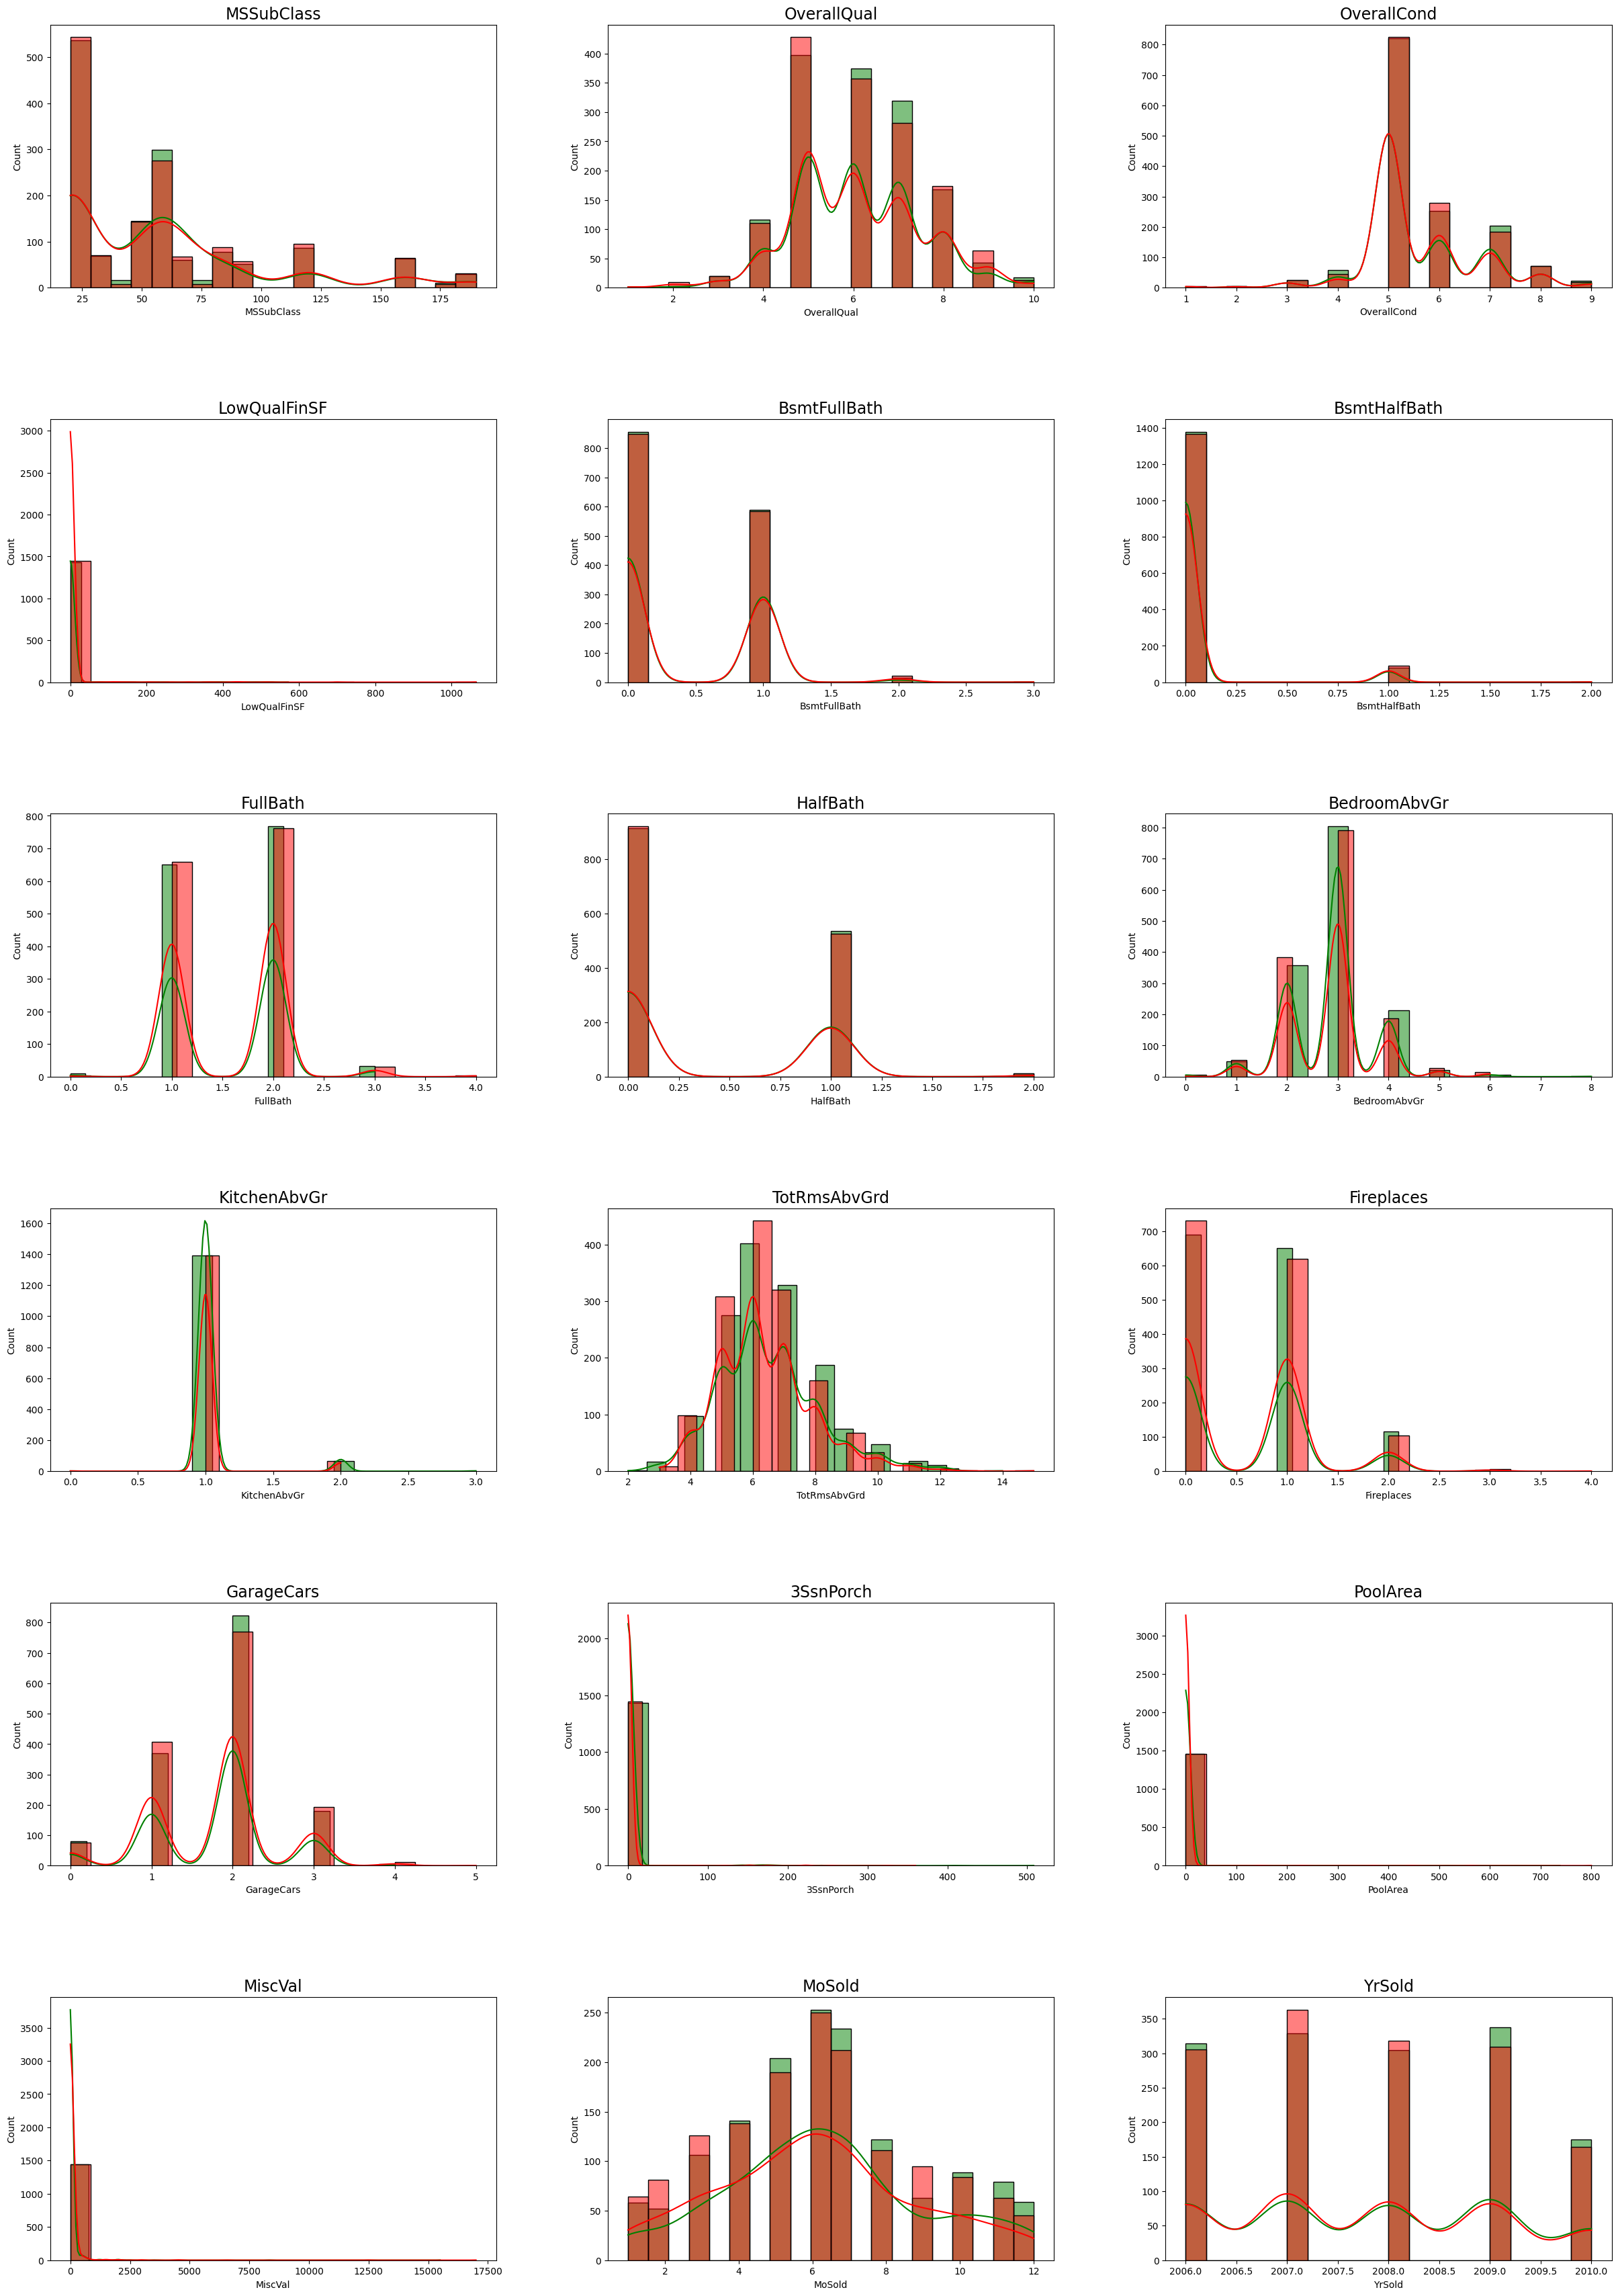

In [56]:
#visualize numerical data(discrete)
plt.figure(figsize=(30,150))
plt.subplots_adjust(hspace=0.5, wspace=0.25)
for n, col in enumerate(list(discrete)):
    plt.subplot(20,3,n+1)
    sns.histplot(df_train_copy[col], bins=20,color='green', kde=True)
    sns.histplot(df_test_copy[col], bins=20,color='red', kde=True)
    plt.title(col, fontsize=17)
plt.show()

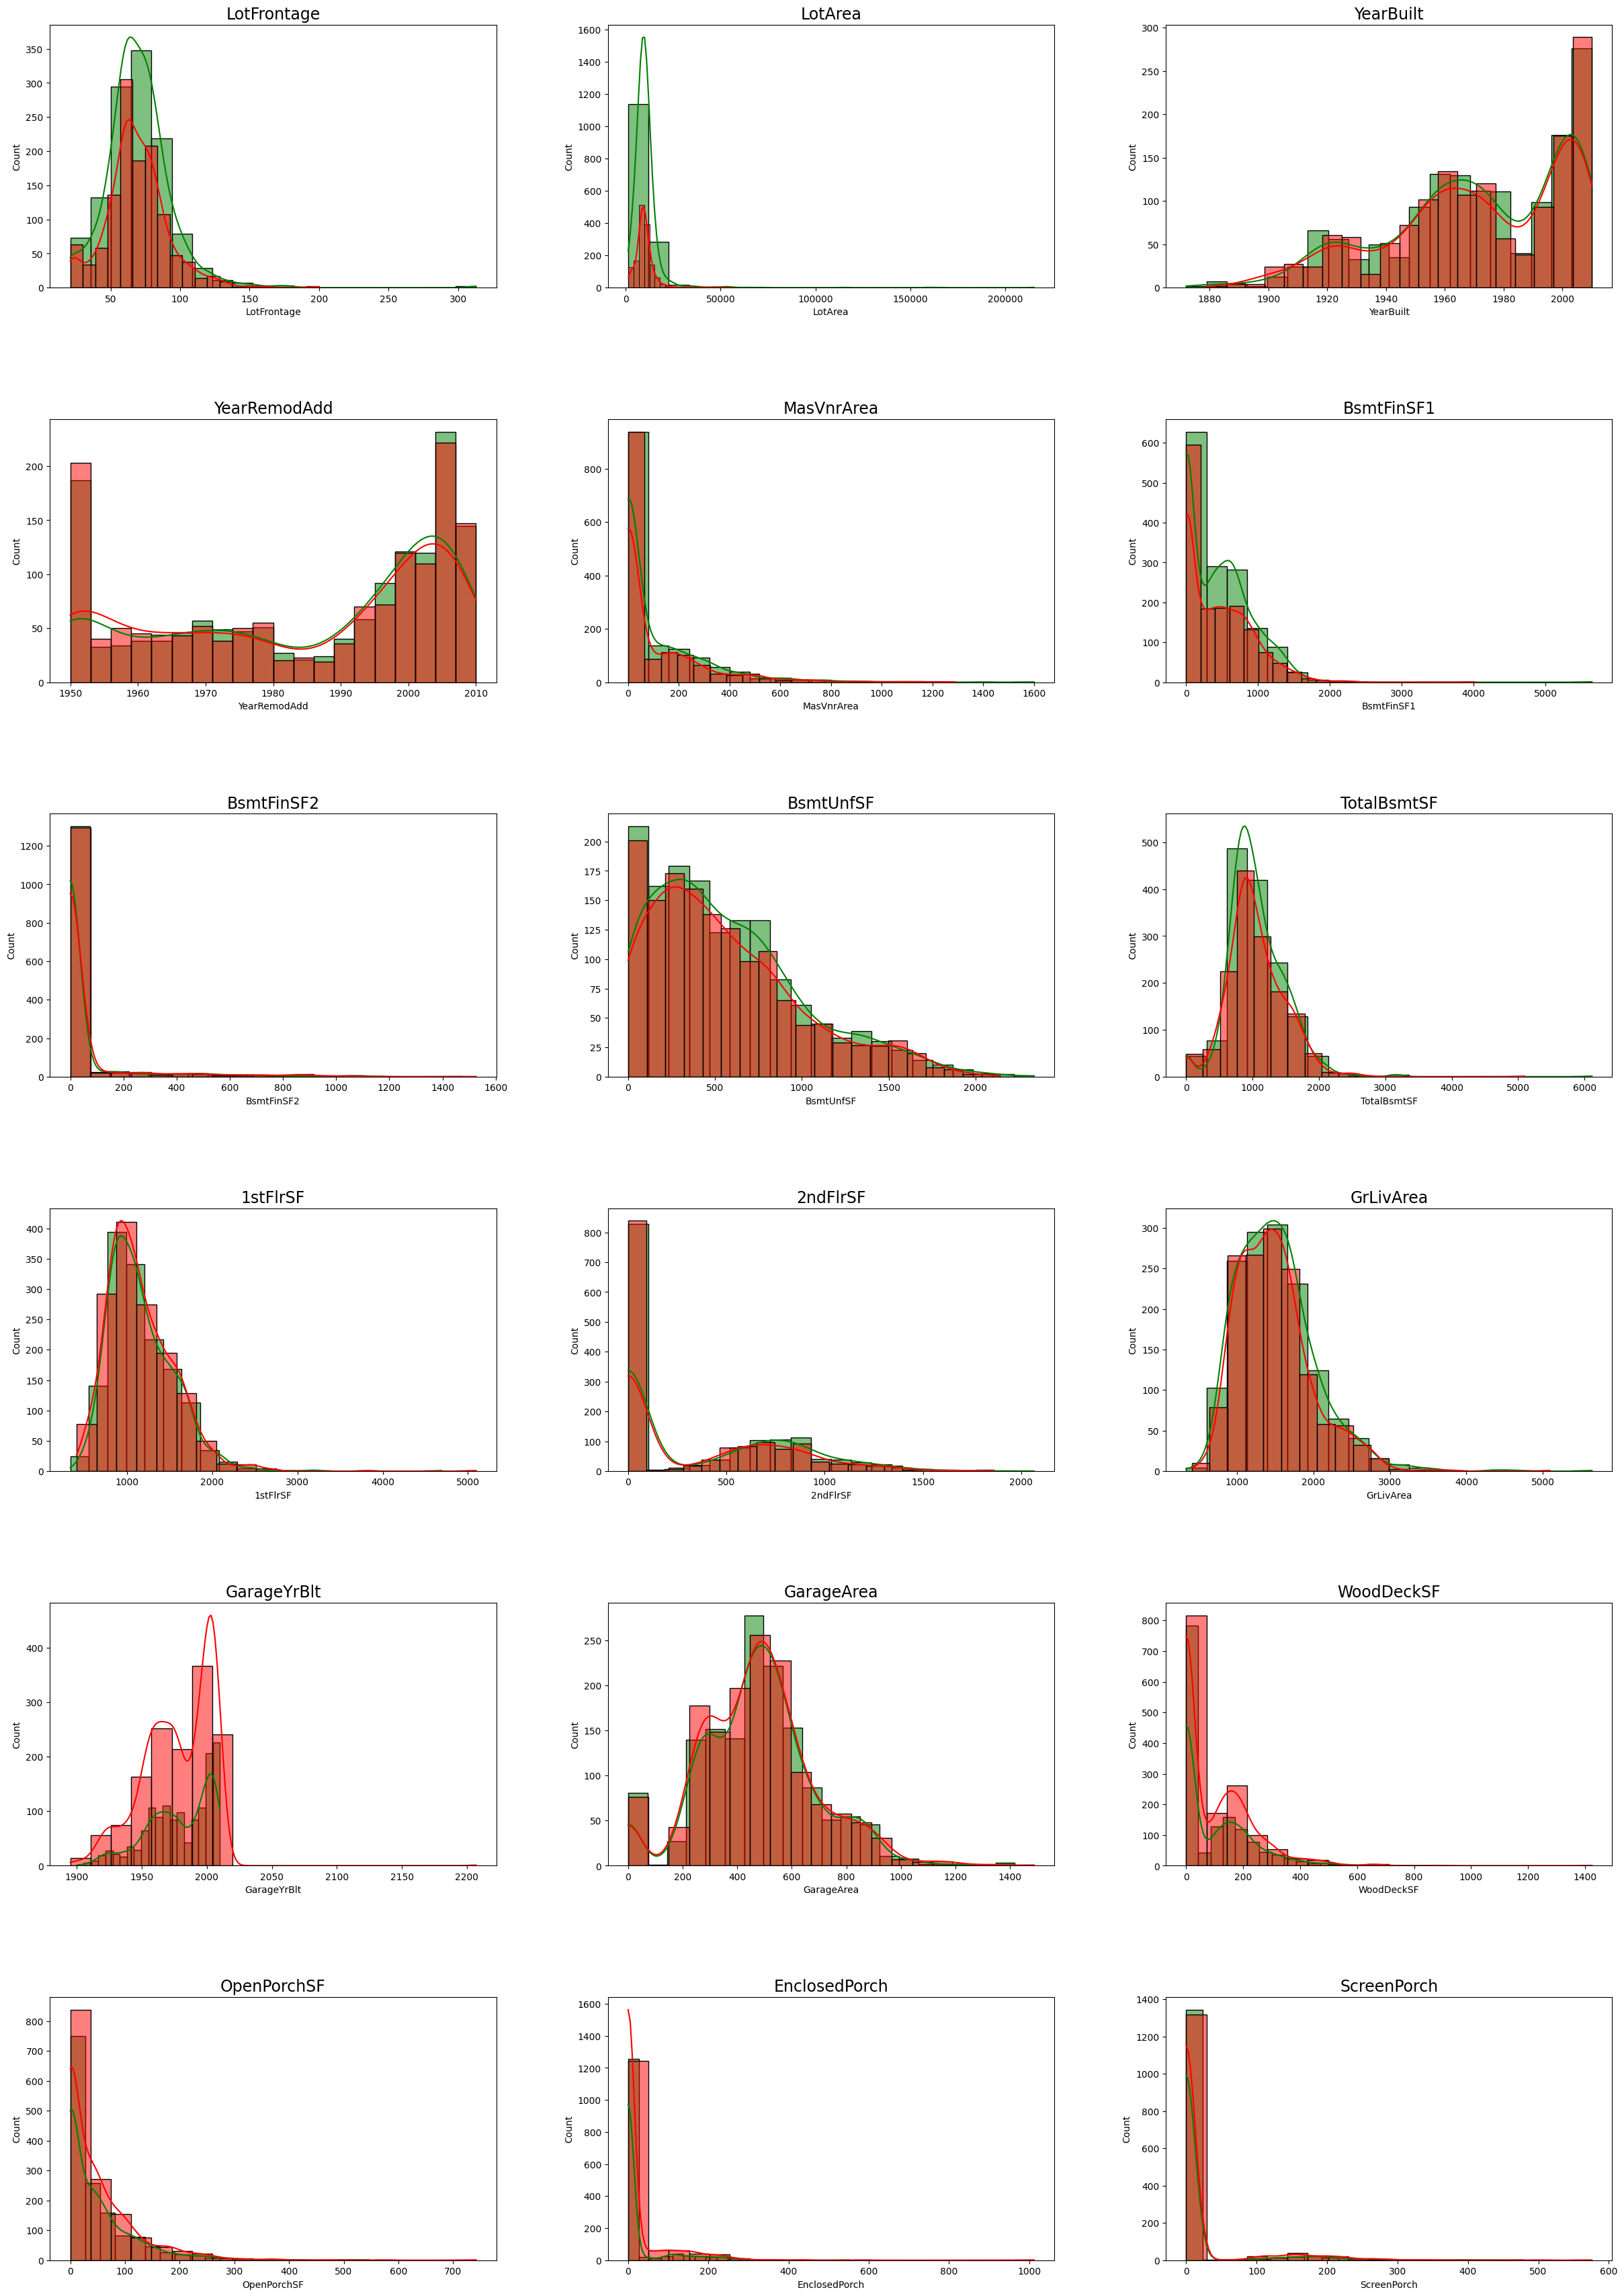

In [57]:
#visualize numerical data(continuous)
plt.figure(figsize=(30,150))
plt.subplots_adjust(hspace=0.5, wspace=0.25)
for n, col in enumerate(list(continuous)):
    plt.subplot(20,3,n+1)
    sns.histplot(df_train_copy[col], bins=20,color='green', kde=True)
    sns.histplot(df_test_copy[col], bins=20,color='red', kde=True)
    plt.title(col, fontsize=17)
plt.show()

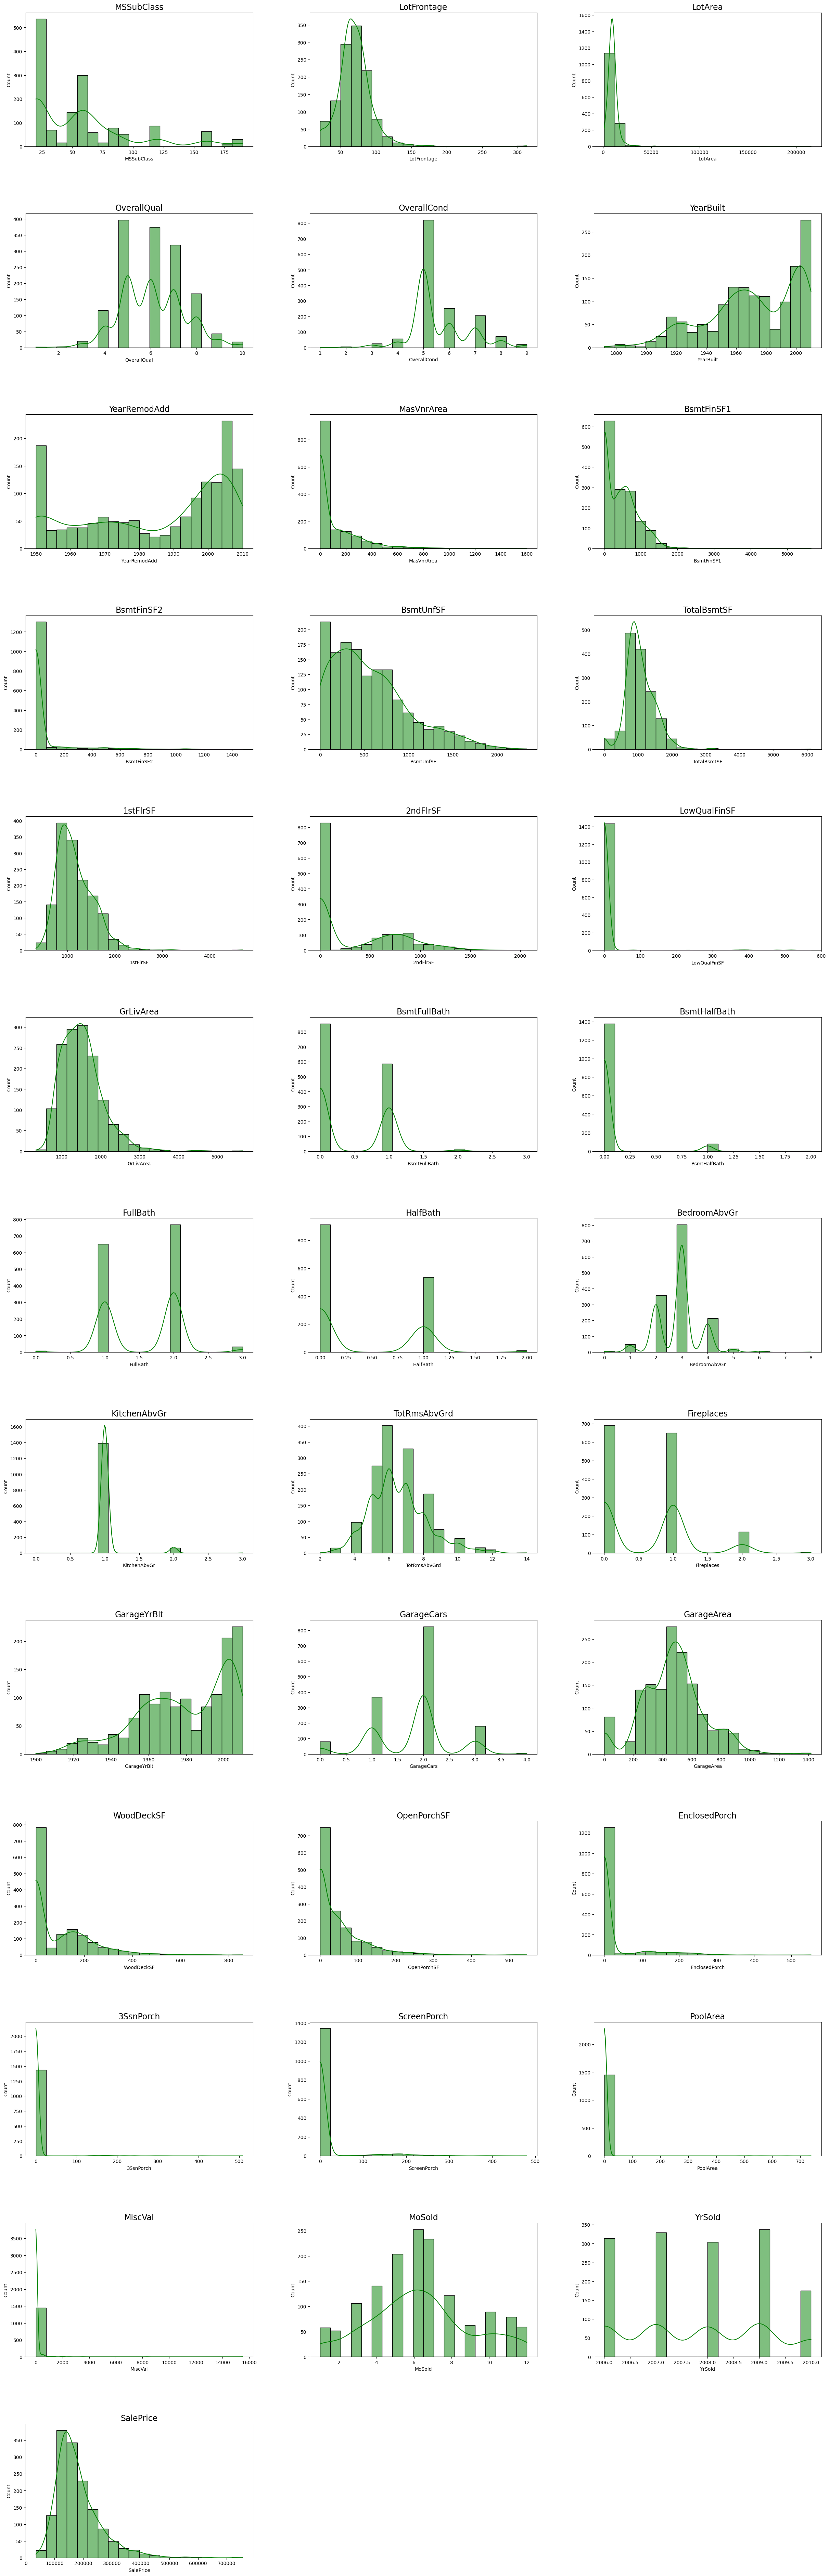

In [58]:
#visualize numerical data
plt.figure(figsize=(30,150))
plt.subplots_adjust(hspace=0.5, wspace=0.25)
for n, col in enumerate(list(numerical)):
    plt.subplot(20,3,n+1)
    sns.histplot(df_train_copy[col], bins=20,color='green', kde=True)
    plt.title(col, fontsize=17)
plt.show()

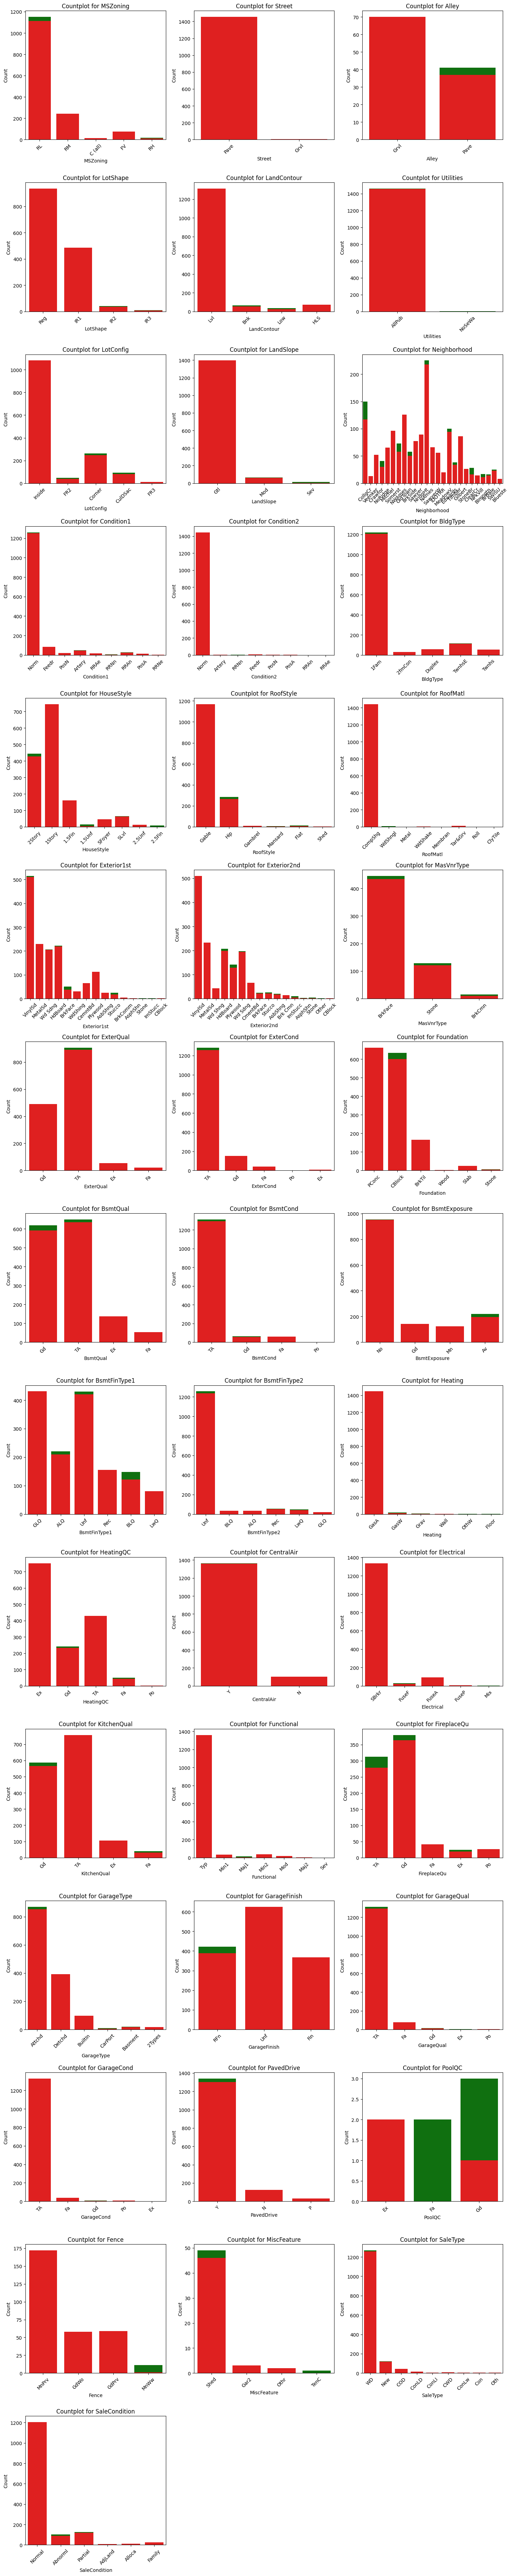

In [59]:
#visualize categorical data(different style)
cols = 3
num_plots = len(categorical)
rows = math.ceil(num_plots / cols)  


fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

axes = axes.flatten()

for i, column in enumerate(categorical):
    sns.countplot(data=df_train_copy, x=column, ax=axes[i], color='green')#, palette='Set2')
    sns.countplot(data=df_test_copy, x=column, ax=axes[i], color='red')#, palette='Set1')
    axes[i].set_title(f'Countplot for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


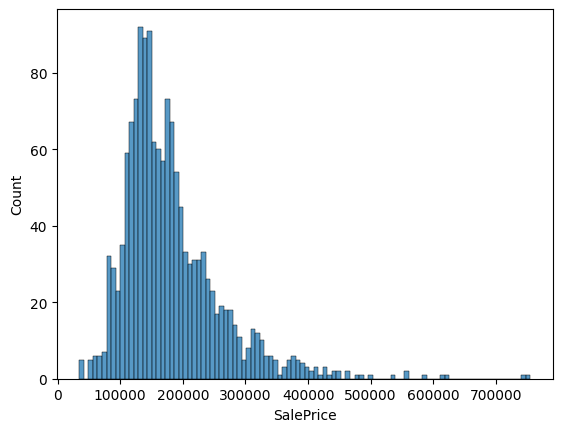

In [60]:
#visualize target feature
sns.histplot(df_train_copy['SalePrice'],bins=100)

print(f'Skewness: {df_train_copy.SalePrice.skew()}')
print(f'Kurtosis: {df_train_copy.SalePrice.kurt()}')

## 6. Analyze the correlations between attributes.

In [61]:
#check correlations (numerical)
num_corr = numerical.corr()

<Axes: >

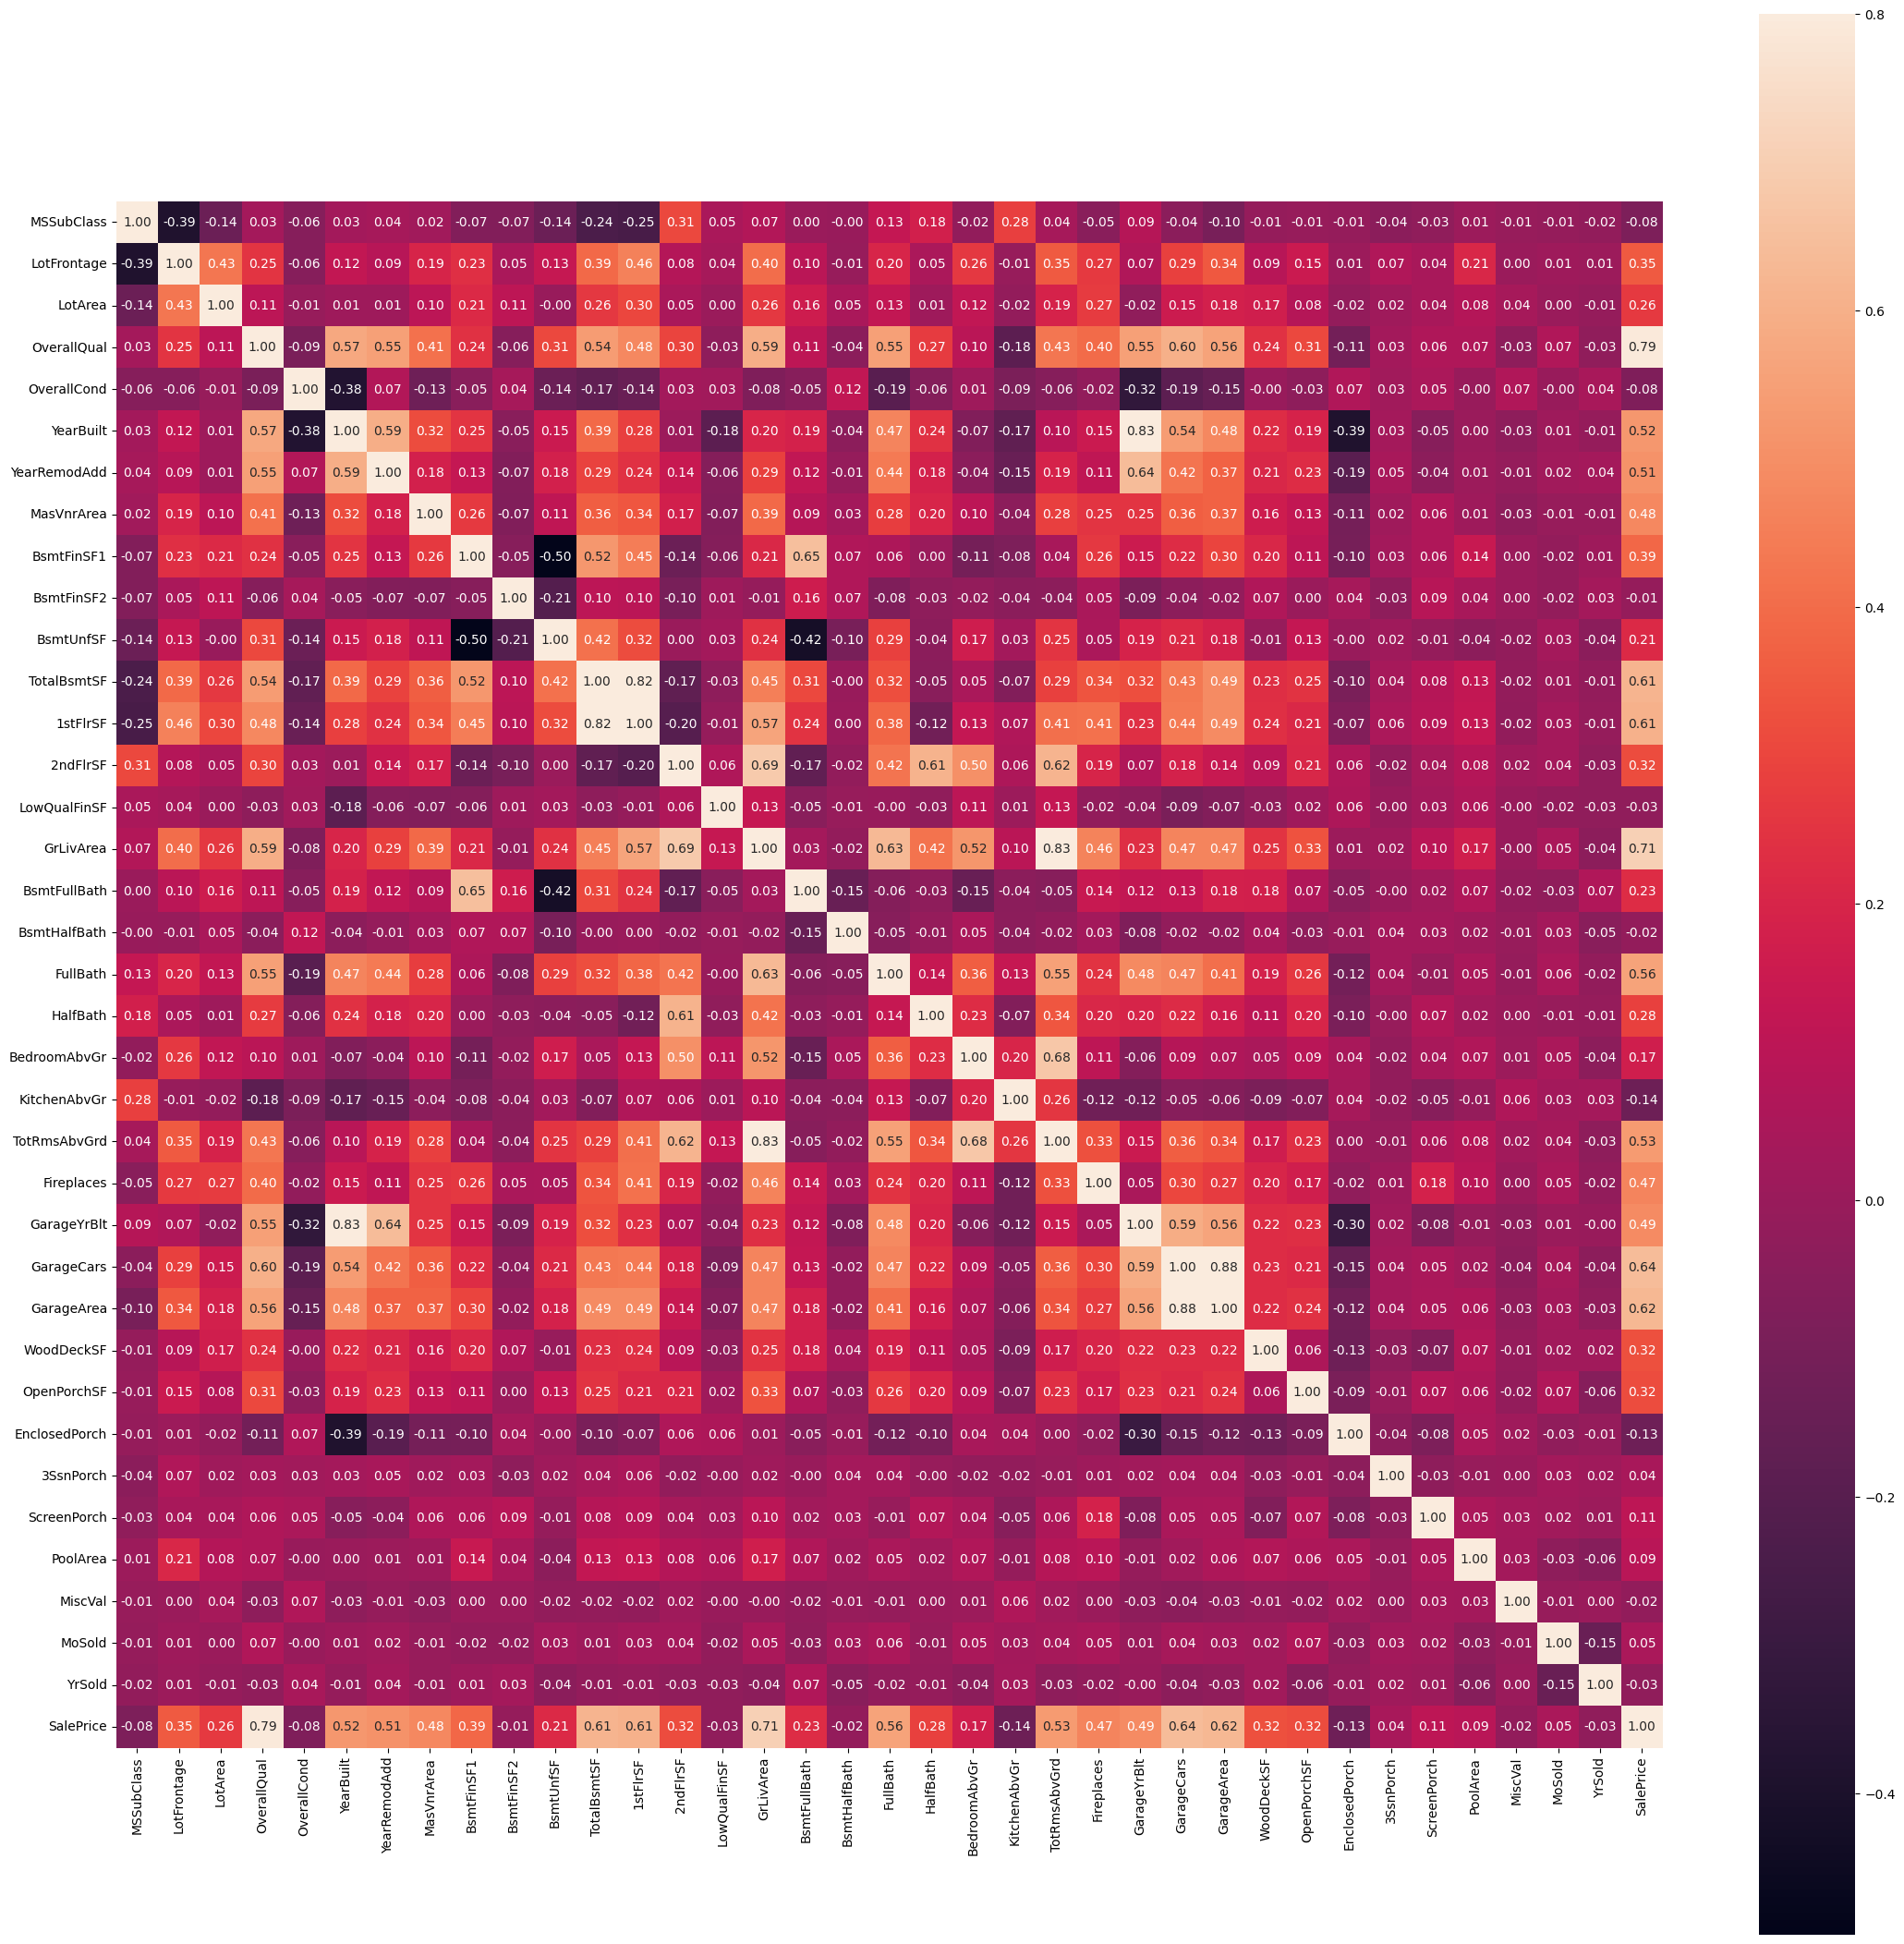

In [62]:
#numerical correlations matrix
f, ax = plt.subplots(figsize=(27,27))
sns.heatmap(num_corr, vmax=.8, square=True, annot=True, fmt='.2f')

In [63]:
#correlation with each other
corr_pairs = num_corr.abs().stack().reset_index()
corr_pairs.columns=['Feature 1','Feature 2','Correlation']
corr_pairs = corr_pairs[corr_pairs['Feature 1'] < corr_pairs['Feature 2']]
top_corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)
top_corr_pairs.head(10)

Feature 1     Feature 2  Correlation
987    GarageArea    GarageCars         0.88
893   GarageYrBlt     YearBuilt         0.83
577     GrLivArea  TotRmsAbvGrd         0.83
455      1stFlrSF   TotalBsmtSF         0.82
147   OverallQual     SalePrice         0.79
591     GrLivArea     SalePrice         0.71
496      2ndFlrSF     GrLivArea         0.69
762  BedroomAbvGr  TotRmsAbvGrd         0.68
312    BsmtFinSF1  BsmtFullBath         0.65
894   GarageYrBlt  YearRemodAdd         0.64

In [64]:
#correlation with saleprice
num_corr_w_saleprice = num_corr.sort_values(by='SalePrice', ascending=False)[['SalePrice']][:]
num_corr_w_saleprice

SalePrice
SalePrice           1.00
OverallQual         0.79
GrLivArea           0.71
GarageCars          0.64
GarageArea          0.62
TotalBsmtSF         0.61
1stFlrSF            0.61
FullBath            0.56
TotRmsAbvGrd        0.53
YearBuilt           0.52
YearRemodAdd        0.51
GarageYrBlt         0.49
MasVnrArea          0.48
Fireplaces          0.47
BsmtFinSF1          0.39
LotFrontage         0.35
WoodDeckSF          0.32
2ndFlrSF            0.32
OpenPorchSF         0.32
HalfBath            0.28
LotArea             0.26
BsmtFullBath        0.23
BsmtUnfSF           0.21
BedroomAbvGr        0.17
ScreenPorch         0.11
PoolArea            0.09
MoSold              0.05
3SsnPorch           0.04
BsmtFinSF2         -0.01
BsmtHalfBath       -0.02
MiscVal            -0.02
LowQualFinSF       -0.03
YrSold             -0.03
OverallCond        -0.08
MSSubClass         -0.08
EnclosedPorch      -0.13
KitchenAbvGr       -0.14

## 7. Check the linearity of features

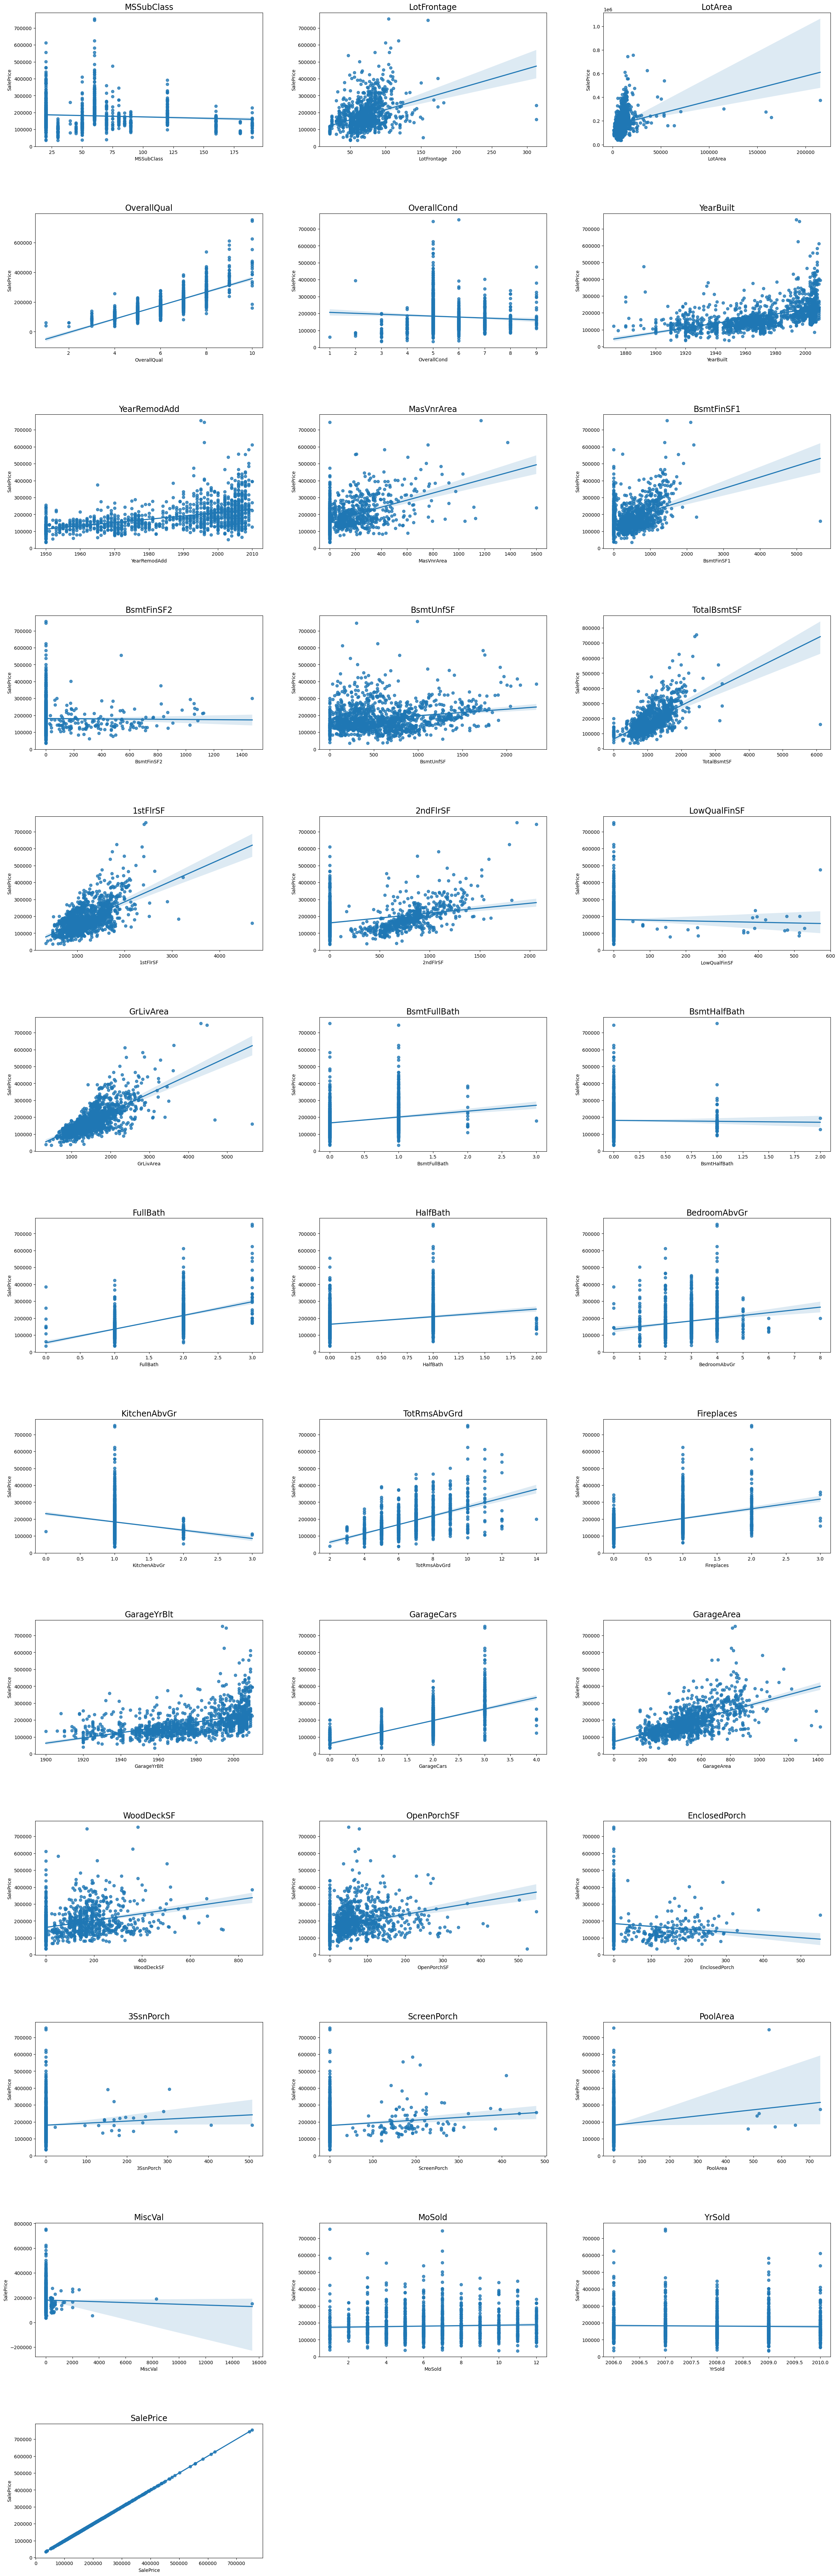

In [65]:
#visualize linearity
plt.figure(figsize=(30,150))
plt.subplots_adjust(hspace=0.5, wspace=0.25)
for n, col in enumerate(list(numerical)):
    plt.subplot(20,3,n+1)
    sns.regplot(data= df_train, x= col, y= 'SalePrice')
    plt.title(col, fontsize=17)
plt.show()

## 8. Summary

* Many columns contain missing data. Features with a small number of missing values will be imputed, while those with many will be removed.
* Some features have one dominant category or mostly contain the value 0 — these will be removed.
* The distributions of some features, including the target variable, are skewed — appropriate transformations will be applied.
* Some features are highly correlated — they will be combined into a single variable.
* Not all features exhibit linearity.

# Data preparation

In [66]:
#data to work on
df_to_handle = combined_data.copy().reset_index(drop=True)
len(df_train), len(df_test), len(df_to_handle)

(1460, 1459, 2919)

### Generating statistics to guide the data cleaning process

In [67]:
#find % of dominant value
train_dominant_val = df_train.copy().apply(lambda col: col.value_counts(normalize=True).iloc[0])
train_dominant_val_pct = (train_dominant_val * 100).round(2).sort_values(ascending=False)
train_dominant_val_pct

Utilities       99.93
Street          99.59
PoolArea        99.52
Condition2      98.97
3SsnPorch       98.36
LowQualFinSF    98.22
RoofMatl        98.22
Heating         97.81
MiscVal         96.44
GarageCond      96.16
KitchenAbvGr    95.34
GarageQual      95.07
LandSlope       94.66
BsmtHalfBath    94.38
CentralAir      93.49
Functional      93.15
BsmtCond        92.13
ScreenPorch     92.05
PavedDrive      91.78
Electrical      91.43
MiscFeature     90.74
LandContour     89.79
BsmtFinSF2      88.56
BsmtFinType2    88.33
ExterCond       87.81
SaleType        86.78
Condition1      86.30
EnclosedPorch   85.75
BldgType        83.56
SaleCondition   82.05
MSZoning        78.84
RoofStyle       78.15
MasVnrType      75.68
LotConfig       72.05
BsmtExposure    67.02
LotShape        63.36
GarageType      63.09
HalfBath        62.53
ExterQual       62.05
MasVnrArea      59.30
BsmtFullBath    58.63
2ndFlrSF        56.78
GarageCars      56.44
OverallCond     56.23
Fence           55.87
BedroomAbv

In [68]:
df_train_pieces = num_cat_data_described.join(num_corr_w_saleprice)
df_train_statistics = df_train_pieces.join(train_dominant_val_pct.rename('%dominant_val'))

In [69]:
categorical_with_saleprice = pd.concat([categorical,df_train.copy()['SalePrice']],axis=1)

In [70]:
#find statistic and p-value of categorical feature using kruskal test
group_col = 'SalePrice'
feature_cols = categorical_with_saleprice.columns.drop(group_col)
results = {}

for col in feature_cols:
    groups = [group[col].values for name, group in categorical_with_saleprice.groupby(group_col)]
    stat, p = kruskal(*groups)
    results[col] = {'statistic': stat.round(2), 'p-value': p.round(2)}

results_df = pd.DataFrame(results).T
print(results_df)

               statistic  p-value
MSZoning          764.62     0.00
Street            887.70     0.00
Alley                NaN      NaN
LotShape          787.89     0.00
LandContour       686.94     0.24
Utilities         242.33     1.00
LotConfig         645.87     0.67
LandSlope         727.68     0.04
Neighborhood      731.94     0.03
Condition1        596.45     0.97
Condition2        630.45     0.81
BldgType          655.90     0.56
HouseStyle        686.23     0.25
RoofStyle         728.88     0.04
RoofMatl          602.46     0.95
Exterior1st       630.60     0.80
Exterior2nd       648.27     0.64
MasVnrType           NaN      NaN
ExterQual        1035.18     0.00
ExterCond         605.05     0.94
Foundation        853.34     0.00
BsmtQual             NaN      NaN
BsmtCond             NaN      NaN
BsmtExposure         NaN      NaN
BsmtFinType1         NaN      NaN
BsmtFinType2         NaN      NaN
Heating           659.15     0.52
HeatingQC         766.85     0.00
CentralAir    

In [71]:
final_df_train_statistics = df_train_statistics.join(results_df['p-value'])

In [72]:
final_df_train_statistics.rename(columns={'SalePrice':'corr_with_saleprice'},inplace=True)
final_df_train_statistics.head()

type  count  nunique  %unique  null  %null  \
MSSubClass     int64   1460       15     1.03     0   0.00   
LotFrontage  float64   1201      110     7.53   259  17.74   
LotArea        int64   1460     1073    73.49     0   0.00   
OverallQual    int64   1460       10     0.68     0   0.00   
OverallCond    int64   1460        9     0.62     0   0.00   

             corr_with_saleprice  %dominant_val  p-value  
MSSubClass                 -0.08          36.71      NaN  
LotFrontage                 0.35          11.91      NaN  
LotArea                     0.26           1.71      NaN  
OverallQual                 0.79          27.19      NaN  
OverallCond                -0.08          56.23      NaN

## 1. Data cleaning

### Drop columns

#### Features were excluded based on the following criteria:


* **Low correlation with the target variable** — Numerical features with an absolute correlation coefficient below 0.2 were removed, 
as they show weak linear or monotonic relationships with the target and likely contribute little to the model's predictive power.

* **High category dominance** — Categorical features where a single category accounted for more than 95% of the values were excluded due to 
insufficient variability, making them uninformative for distinguishing differences in the target.

* **Lack of statistical significance** — Categorical features with a Kruskal-Wallis test p-value greater than 0.05 were removed, 
indicating that differences in the target variable across categories were not statistically significant.

* **High proportion of missing values** — Features with more than 30% missing data were excluded to reduce noise and avoid excessive imputation, 
which could introduce bias or degrade model performance.

In [73]:
#drop columns with many null values
final_df_train_statistics.sort_values(['%null'],ascending=False).head(10)

type  count  nunique  %unique  null  %null  \
PoolQC         object      7        3     0.21  1453  99.52   
MiscFeature    object     54        4     0.27  1406  96.30   
Alley          object     91        2     0.14  1369  93.77   
Fence          object    281        4     0.27  1179  80.75   
MasVnrType     object    588        3     0.21   872  59.73   
FireplaceQu    object    770        5     0.34   690  47.26   
LotFrontage   float64   1201      110     7.53   259  17.74   
GarageFinish   object   1379        3     0.21    81   5.55   
GarageYrBlt   float64   1379       97     6.64    81   5.55   
GarageCond     object   1379        5     0.34    81   5.55   

              corr_with_saleprice  %dominant_val  p-value  
PoolQC                        NaN          42.86      NaN  
MiscFeature                   NaN          90.74      NaN  
Alley                         NaN          54.95      NaN  
Fence                         NaN          55.87      NaN  
MasVnrType                    NaN          75.68      NaN  
FireplaceQu                   NaN          49.35      NaN  
LotFrontage                  0.35          11.91      NaN  
GarageFinish                  NaN          43.87      NaN  
GarageYrBlt                  0.49           4.71      NaN  
GarageCond                    NaN          96.16      NaN

In [74]:
cols_with_many_null_values = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu']

In [75]:
#drop columns with one dominant value
final_df_train_statistics.sort_values(['%dominant_val'],ascending=False)

type  count  nunique  %unique  null  %null  \
Utilities       object   1460        2     0.14     0   0.00   
Street          object   1460        2     0.14     0   0.00   
PoolArea         int64   1460        8     0.55     0   0.00   
Condition2      object   1460        8     0.55     0   0.00   
3SsnPorch        int64   1460       20     1.37     0   0.00   
LowQualFinSF     int64   1460       24     1.64     0   0.00   
RoofMatl        object   1460        8     0.55     0   0.00   
Heating         object   1460        6     0.41     0   0.00   
MiscVal          int64   1460       21     1.44     0   0.00   
GarageCond      object   1379        5     0.34    81   5.55   
KitchenAbvGr     int64   1460        4     0.27     0   0.00   
GarageQual      object   1379        5     0.34    81   5.55   
LandSlope       object   1460        3     0.21     0   0.00   
BsmtHalfBath     int64   1460        3     0.21     0   0.00   
CentralAir      object   1460        2     0.14     0   0.00   
Functional      object   1460        7     0.48     0   0.00   
BsmtCond        object   1423        4     0.27    37   2.53   
ScreenPorch      int64   1460       76     5.21     0   0.00   
PavedDrive      object   1460        3     0.21     0   0.00   
Electrical      object   1459        5     0.34     1   0.07   
MiscFeature     object     54        4     0.27  1406  96.30   
LandContour     object   1460        4     0.27     0   0.00   
BsmtFinSF2       int64   1460      144     9.86     0   0.00   
BsmtFinType2    object   1422        6     0.41    38   2.60   
ExterCond       object   1460        5     0.34     0   0.00   
SaleType        object   1460        9     0.62     0   0.00   
Condition1      object   1460        9     0.62     0   0.00   
EnclosedPorch    int64   1460      120     8.22     0   0.00   
BldgType        object   1460        5     0.34     0   0.00   
SaleCondition   object   1460        6     0.41     0   0.00   
MSZoning        object   1460        5     0.34     0   0.00   
RoofStyle       object   1460        6     0.41     0   0.00   
MasVnrType      object    588        3     0.21   872  59.73   
LotConfig       object   1460        5     0.34     0   0.00   
BsmtExposure    object   1422        4     0.27    38   2.60   
LotShape        object   1460        4     0.27     0   0.00   
GarageType      object   1379        6     0.41    81   5.55   
HalfBath         int64   1460        3     0.21     0   0.00   
ExterQual       object   1460        4     0.27     0   0.00   
MasVnrArea     float64   1452      327    22.40     8   0.55   
BsmtFullBath     int64   1460        4     0.27     0   0.00   
2ndFlrSF         int64   1460      417    28.56     0   0.00   
GarageCars       int64   1460        5     0.34     0   0.00   
OverallCond      int64   1460        9     0.62     0   0.00   
Fence           object    281        4     0.27  1179  80.75   
BedroomAbvGr     int64   1460        8     0.55     0   0.00   
Alley           object     91        2     0.14  1369  93.77   
FullBath         int64   1460        4     0.27     0   0.00   
WoodDeckSF       int64   1460      274    18.77     0   0.00   
HeatingQC       object   1460        5     0.34     0   0.00   
KitchenQual     object   1460        4     0.27     0   0.00   
HouseStyle      object   1460        8     0.55     0   0.00   
FireplaceQu     object    770        5     0.34   690  47.26   
Fireplaces       int64   1460        4     0.27     0   0.00   
BsmtQual        object   1423        4     0.27    37   2.53   
OpenPorchSF      int64   1460      202    13.84     0   0.00   
Foundation      object   1460        6     0.41     0   0.00   
GarageFinish    object   1379        3     0.21    81   5.55   
PoolQC          object      7        3     0.21  1453  99.52   
MSSubClass       int64   1460       15     1.03     0   0.00   
Exterior1st     object   1460       15     1.03     0   0.00   
Exterior2nd     object   1460       16     1.10   

In [76]:
cols_dominant = ['Utilities','Street','PoolArea','Condition2','3SsnPorch','LowQualFinSF','RoofMatl','Heating','MiscVal','GarageCond','KitchenAbvGr','GarageQual',]

In [77]:
#drop columns with lack of statistical significance
final_df_train_statistics.sort_values(['p-value'],ascending=False)

type  count  nunique  %unique  null  %null  \
Utilities       object   1460        2     0.14     0   0.00   
Functional      object   1460        7     0.48     0   0.00   
Condition1      object   1460        9     0.62     0   0.00   
RoofMatl        object   1460        8     0.55     0   0.00   
ExterCond       object   1460        5     0.34     0   0.00   
Condition2      object   1460        8     0.55     0   0.00   
Exterior1st     object   1460       15     1.03     0   0.00   
LotConfig       object   1460        5     0.34     0   0.00   
Exterior2nd     object   1460       16     1.10     0   0.00   
BldgType        object   1460        5     0.34     0   0.00   
Heating         object   1460        6     0.41     0   0.00   
PavedDrive      object   1460        3     0.21     0   0.00   
HouseStyle      object   1460        8     0.55     0   0.00   
LandContour     object   1460        4     0.27     0   0.00   
RoofStyle       object   1460        6     0.41     0   0.00   
LandSlope       object   1460        3     0.21     0   0.00   
Neighborhood    object   1460       25     1.71     0   0.00   
LotShape        object   1460        4     0.27     0   0.00   
MSZoning        object   1460        5     0.34     0   0.00   
Street          object   1460        2     0.14     0   0.00   
ExterQual       object   1460        4     0.27     0   0.00   
Foundation      object   1460        6     0.41     0   0.00   
HeatingQC       object   1460        5     0.34     0   0.00   
KitchenQual     object   1460        4     0.27     0   0.00   
CentralAir      object   1460        2     0.14     0   0.00   
SaleType        object   1460        9     0.62     0   0.00   
SaleCondition   object   1460        6     0.41     0   0.00   
MSSubClass       int64   1460       15     1.03     0   0.00   
LotFrontage    float64   1201      110     7.53   259  17.74   
LotArea          int64   1460     1073    73.49     0   0.00   
OverallQual      int64   1460       10     0.68     0   0.00   
OverallCond      int64   1460        9     0.62     0   0.00   
YearBuilt        int64   1460      112     7.67     0   0.00   
YearRemodAdd     int64   1460       61     4.18     0   0.00   
MasVnrArea     float64   1452      327    22.40     8   0.55   
BsmtFinSF1       int64   1460      637    43.63     0   0.00   
BsmtFinSF2       int64   1460      144     9.86     0   0.00   
BsmtUnfSF        int64   1460      780    53.42     0   0.00   
TotalBsmtSF      int64   1460      721    49.38     0   0.00   
1stFlrSF         int64   1460      753    51.58     0   0.00   
2ndFlrSF         int64   1460      417    28.56     0   0.00   
LowQualFinSF     int64   1460       24     1.64     0   0.00   
GrLivArea        int64   1460      861    58.97     0   0.00   
BsmtFullBath     int64   1460        4     0.27     0   0.00   
BsmtHalfBath     int64   1460        3     0.21     0   0.00   
FullBath         int64   1460        4     0.27     0   0.00   
HalfBath         int64   1460        3     0.21     0   0.00   
BedroomAbvGr     int64   1460        8     0.55     0   0.00   
KitchenAbvGr     int64   1460        4     0.27     0   0.00   
TotRmsAbvGrd     int64   1460       12     0.82     0   0.00   
Fireplaces       int64   1460        4     0.27     0   0.00   
GarageYrBlt    float64   1379       97     6.64    81   5.55   
GarageCars       int64   1460        5     0.34     0   0.00   
GarageArea       int64   1460      441    30.21     0   0.00   
WoodDeckSF       int64   1460      274    18.77     0   0.00   
OpenPorchSF      int64   1460      202    13.84     0   0.00   
EnclosedPorch    int64   1460      120     8.22     0   0.00   
3SsnPorch        int64   1460       20     1.37     0   0.00   
ScreenPorch      int64   1460       76     5.21     0   0.00   
PoolArea         int64   1460        8     0.55     0   0.00   
MiscVal          int64   1460       21     1.44     0   0.00   
MoSold           int64   1460       12     0.82   

In [78]:
cols_kruskal = ['Utilities','Functional','Condition1','RoofMatl','ExterCond','Condition2','Exterior1st','LotConfig','Exterior2nd','BldgType','Heating','PavedDrive','HouseStyle',
                'LandContour']

In [79]:
final_stats_df = final_df_train_statistics.sort_values(['corr_with_saleprice'],ascending=False)
final_stats_df

type  count  nunique  %unique  null  %null  \
SalePrice        int64   1460      663    45.41     0   0.00   
OverallQual      int64   1460       10     0.68     0   0.00   
GrLivArea        int64   1460      861    58.97     0   0.00   
GarageCars       int64   1460        5     0.34     0   0.00   
GarageArea       int64   1460      441    30.21     0   0.00   
TotalBsmtSF      int64   1460      721    49.38     0   0.00   
1stFlrSF         int64   1460      753    51.58     0   0.00   
FullBath         int64   1460        4     0.27     0   0.00   
TotRmsAbvGrd     int64   1460       12     0.82     0   0.00   
YearBuilt        int64   1460      112     7.67     0   0.00   
YearRemodAdd     int64   1460       61     4.18     0   0.00   
GarageYrBlt    float64   1379       97     6.64    81   5.55   
MasVnrArea     float64   1452      327    22.40     8   0.55   
Fireplaces       int64   1460        4     0.27     0   0.00   
BsmtFinSF1       int64   1460      637    43.63     0   0.00   
LotFrontage    float64   1201      110     7.53   259  17.74   
WoodDeckSF       int64   1460      274    18.77     0   0.00   
2ndFlrSF         int64   1460      417    28.56     0   0.00   
OpenPorchSF      int64   1460      202    13.84     0   0.00   
HalfBath         int64   1460        3     0.21     0   0.00   
LotArea          int64   1460     1073    73.49     0   0.00   
BsmtFullBath     int64   1460        4     0.27     0   0.00   
BsmtUnfSF        int64   1460      780    53.42     0   0.00   
BedroomAbvGr     int64   1460        8     0.55     0   0.00   
ScreenPorch      int64   1460       76     5.21     0   0.00   
PoolArea         int64   1460        8     0.55     0   0.00   
MoSold           int64   1460       12     0.82     0   0.00   
3SsnPorch        int64   1460       20     1.37     0   0.00   
BsmtFinSF2       int64   1460      144     9.86     0   0.00   
BsmtHalfBath     int64   1460        3     0.21     0   0.00   
MiscVal          int64   1460       21     1.44     0   0.00   
LowQualFinSF     int64   1460       24     1.64     0   0.00   
YrSold           int64   1460        5     0.34     0   0.00   
OverallCond      int64   1460        9     0.62     0   0.00   
MSSubClass       int64   1460       15     1.03     0   0.00   
EnclosedPorch    int64   1460      120     8.22     0   0.00   
KitchenAbvGr     int64   1460        4     0.27     0   0.00   
MSZoning        object   1460        5     0.34     0   0.00   
Street          object   1460        2     0.14     0   0.00   
Alley           object     91        2     0.14  1369  93.77   
LotShape        object   1460        4     0.27     0   0.00   
LandContour     object   1460        4     0.27     0   0.00   
Utilities       object   1460        2     0.14     0   0.00   
LotConfig       object   1460        5     0.34     0   0.00   
LandSlope       object   1460        3     0.21     0   0.00   
Neighborhood    object   1460       25     1.71     0   0.00   
Condition1      object   1460        9     0.62     0   0.00   
Condition2      object   1460        8     0.55     0   0.00   
BldgType        object   1460        5     0.34     0   0.00   
HouseStyle      object   1460        8     0.55     0   0.00   
RoofStyle       object   1460        6     0.41     0   0.00   
RoofMatl        object   1460        8     0.55     0   0.00   
Exterior1st     object   1460       15     1.03     0   0.00   
Exterior2nd     object   1460       16     1.10     0   0.00   
MasVnrType      object    588        3     0.21   872  59.73   
ExterQual       object   1460        4     0.27     0   0.00   
ExterCond       object   1460        5     0.34     0   0.00   
Foundation      object   1460        6     0.41     0   0.00   
BsmtQual        object   1423        4     0.27    37   2.53   
BsmtCond        object   1423        4     0.27    37   2.53   
BsmtExposure    object   1422        4     0.27    38   2.60   
BsmtFinType1    object   1423        6     0.41   

In [80]:
final_stats_df[final_stats_df['corr_with_saleprice'].between(-0.2,0.2)]

type  count  nunique  %unique  null  %null  \
BedroomAbvGr   int64   1460        8     0.55     0   0.00   
ScreenPorch    int64   1460       76     5.21     0   0.00   
PoolArea       int64   1460        8     0.55     0   0.00   
MoSold         int64   1460       12     0.82     0   0.00   
3SsnPorch      int64   1460       20     1.37     0   0.00   
BsmtFinSF2     int64   1460      144     9.86     0   0.00   
BsmtHalfBath   int64   1460        3     0.21     0   0.00   
MiscVal        int64   1460       21     1.44     0   0.00   
LowQualFinSF   int64   1460       24     1.64     0   0.00   
YrSold         int64   1460        5     0.34     0   0.00   
OverallCond    int64   1460        9     0.62     0   0.00   
MSSubClass     int64   1460       15     1.03     0   0.00   
EnclosedPorch  int64   1460      120     8.22     0   0.00   
KitchenAbvGr   int64   1460        4     0.27     0   0.00   

               corr_with_saleprice  %dominant_val  p-value  
BedroomAbvGr                  0.17          55.07      NaN  
ScreenPorch                   0.11          92.05      NaN  
PoolArea                      0.09          99.52      NaN  
MoSold                        0.05          17.33      NaN  
3SsnPorch                     0.04          98.36      NaN  
BsmtFinSF2                   -0.01          88.56      NaN  
BsmtHalfBath                 -0.02          94.38      NaN  
MiscVal                      -0.02          96.44      NaN  
LowQualFinSF                 -0.03          98.22      NaN  
YrSold                       -0.03          23.15      NaN  
OverallCond                  -0.08          56.23      NaN  
MSSubClass                   -0.08          36.71      NaN  
EnclosedPorch                -0.13          85.75      NaN  
KitchenAbvGr                 -0.14          95.34      NaN

In [81]:
cols_low_corr = list(final_stats_df[final_stats_df['corr_with_saleprice'].between(-0.2,0.2)].index)

In [82]:
#aggregated cols to drop
cols_to_drop = list(set(cols_with_many_null_values + cols_dominant + cols_kruskal))
#Correlation measures only linear relationships (Pearson) or monotonic ones (Spearman).
#A feature can still be very useful for a model even if it has zero correlation with the target
cols_to_drop_w_corr = list(set(cols_with_many_null_values + cols_dominant + cols_kruskal + cols_low_corr))
len(cols_to_drop),len(cols_to_drop_w_corr),len(df_to_handle.columns)

(28, 37, 81)

In [83]:
df_dropped_cols = df_to_handle.copy()
df_dropped_cols.drop(cols_to_drop, axis=1, inplace=True)
#len(combined_data.columns),len(df_to_handle.columns)

### Fill Missing Values

In [84]:
dropped_df_described = DataDescriber(df_dropped_cols, 'full').show_data().sort_values(['null'], ascending=False)
dropped_df_described

type  count  nunique  %unique  null  %null
SalePrice      float64   1460      663    22.71  1459  49.98
LotFrontage    float64   2433      128     4.39   486  16.65
GarageYrBlt    float64   2760      103     3.53   159   5.45
GarageFinish    object   2760        3     0.10   159   5.45
GarageType      object   2762        6     0.21   157   5.38
BsmtCond        object   2837        4     0.14    82   2.81
BsmtExposure    object   2837        4     0.14    82   2.81
BsmtQual        object   2838        4     0.14    81   2.77
BsmtFinType2    object   2839        6     0.21    80   2.74
BsmtFinType1    object   2840        6     0.21    79   2.71
MasVnrArea     float64   2896      444    15.21    23   0.79
MSZoning        object   2915        5     0.17     4   0.14
BsmtFullBath   float64   2917        4     0.14     2   0.07
BsmtHalfBath   float64   2917        3     0.10     2   0.07
TotalBsmtSF    float64   2918     1058    36.25     1   0.03
BsmtFinSF1     float64   2918      991    33.95     1   0.03
GarageCars     float64   2918        6     0.21     1   0.03
KitchenQual     object   2918        4     0.14     1   0.03
BsmtFinSF2     float64   2918      272     9.32     1   0.03
BsmtUnfSF      float64   2918     1135    38.88     1   0.03
GarageArea     float64   2918      603    20.66     1   0.03
SaleType        object   2918        9     0.31     1   0.03
Electrical      object   2918        5     0.17     1   0.03
GrLivArea        int64   2919     1292    44.26     0   0.00
BedroomAbvGr     int64   2919        8     0.27     0   0.00
HalfBath         int64   2919        3     0.10     0   0.00
FullBath         int64   2919        5     0.17     0   0.00
YearBuilt        int64   2919      118     4.04     0   0.00
YearRemodAdd     int64   2919       61     2.09     0   0.00
MSSubClass       int64   2919       16     0.55     0   0.00
LotArea          int64   2919     1951    66.84     0   0.00
OverallQual      int64   2919       10     0.34     0   0.00
1stFlrSF         int64   2919     1083    37.10     0   0.00
2ndFlrSF         int64   2919      635    21.75     0   0.00
OverallCond      int64   2919        9     0.31     0   0.00
WoodDeckSF       int64   2919      379    12.98     0   0.00
Neighborhood    object   2919       25     0.86     0   0.00
LandSlope       object   2919        3     0.10     0   0.00
LotShape        object   2919        4     0.14     0   0.00
YrSold           int64   2919        5     0.17     0   0.00
ScreenPorch      int64   2919      121     4.15     0   0.00
MoSold           int64   2919       12     0.41     0   0.00
OpenPorchSF      int64   2919      252     8.63     0   0.00
EnclosedPorch    int64   2919      183     6.27     0   0.00
Fireplaces       int64   2919        5     0.17     0   0.00
TotRmsAbvGrd     int64   2919       14     0.48     0   0.00
Foundation      object   2919        6     0.21     0   0.00
RoofStyle       object   2919        6     0.21     0   0.00
ExterQual       object   2919        4     0.14     0   0.00
CentralAir      object   2919        2     0.07     0   0.00
HeatingQC       object   2919        5     0.17     0   0.00
SaleCondition   object   2919        6     0.21     0   0.00

#### LotFrontage

<Axes: xlabel='LotArea', ylabel='LotFrontage'>

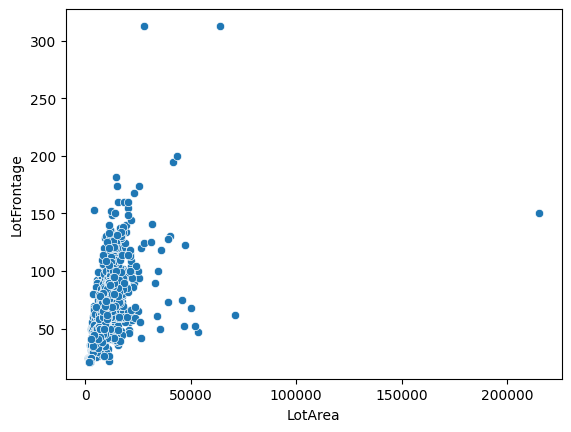

In [85]:
#handle LotFrontage
sns.scatterplot(x=df_dropped_cols['LotArea'], y=df_dropped_cols['LotFrontage'])

In [86]:
lot_frontage_to_handle = df_dropped_cols[['LotArea','LotFrontage']]
lot_frontage_missing = list(lot_frontage_to_handle.loc[lot_frontage_to_handle['LotFrontage'].isna()].index)
lot_frontage_to_train = lot_frontage_to_handle.drop(lot_frontage_missing, axis=0)
lot_frontage_to_predict = lot_frontage_to_handle.loc[lot_frontage_missing,:]

In [87]:
features_train = lot_frontage_to_train[['LotArea']]
target_train = lot_frontage_to_train[['LotFrontage']]

hub_reg = HuberRegressor()
hub_reg.fit(features_train, target_train)

HuberRegressor()

In [88]:
predictions = hub_reg.predict(lot_frontage_to_predict[['LotArea']])
predicted_data = lot_frontage_to_predict.copy()
predicted_data['LotFrontage']=predictions

In [89]:
predicted_data.head()

LotArea  LotFrontage
7     10382        73.36
12    12968        89.17
14    10920        76.65
16    11241        78.61
24     8246        60.31

In [90]:
df_dropped_cols.loc[df_dropped_cols['LotFrontage'].isna(),'LotFrontage'] = predictions

#### Garage

In [91]:
#handle Garage
garage_features_cat = ['GarageType','GarageFinish','GarageCars',]

garage_features_nom = ['GarageYrBlt']

df_dropped_cols.loc[df_dropped_cols['GarageType'].isna(),garage_features_cat] = 0
df_dropped_cols.loc[df_dropped_cols['GarageYrBlt'].isna(),garage_features_nom] = 0
df_dropped_cols.loc[df_dropped_cols['GarageArea'].isna(),'GarageArea'] = 0

#### Basement

In [92]:
#handle Basement
basement_features= ['BsmtQual',
                    'BsmtCond',
                    'BsmtExposure',
                    'BsmtFinType1',
                    'BsmtFinType2']
missing_basement_index = df_dropped_cols.loc[df_dropped_cols['BsmtQual'].isna()].index
df_dropped_cols.loc[missing_basement_index, basement_features] = 'NoBasement'

#### MasVnrArea

<Axes: xlabel='GrLivArea', ylabel='MasVnrArea'>

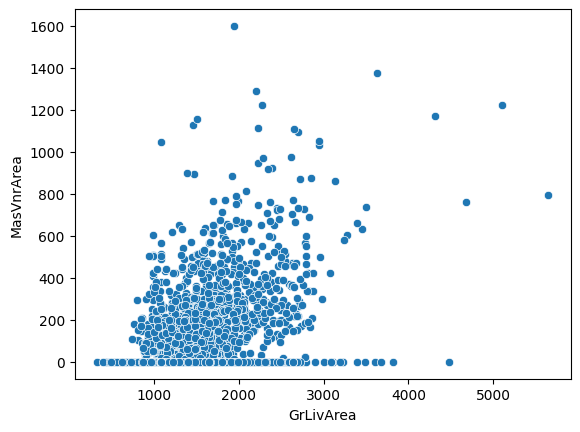

In [93]:
#handle MasVnrArea
sns.scatterplot(x=df_dropped_cols['GrLivArea'], y=df_dropped_cols['MasVnrArea'])

In [94]:
#get ratio GrLivArea/MasVnrArea but use median? or mean?
ratio_mean = df_dropped_cols['GrLivArea'].mean() / df_dropped_cols['MasVnrArea'].mean()


non_zero_median = list(df_dropped_cols.loc[df_dropped_cols['MasVnrArea']>0,:].index)
mas_vnr_area_median = df_dropped_cols.loc[non_zero_median,'MasVnrArea'].median()
ratio_median = df_dropped_cols['GrLivArea'].median() / mas_vnr_area_median

print(f'ratio_mean: {ratio_mean}')
print(f'ratio_median: {ratio_median}')

ratio_mean: 14.684350108850209
ratio_median: 7.130864197530864


In [95]:
df_dropped_cols.loc[df_dropped_cols['MasVnrArea'].isna(), 'MasVnrArea'] = df_dropped_cols['GrLivArea'] / ratio_median

#### Rest of missing values

In [96]:
#check rest of missing values
DataDescriber(df_dropped_cols, 'full').show_data().sort_values(['null'], ascending=False)

type  count  nunique  %unique  null  %null
SalePrice      float64   1460      663    22.71  1459  49.98
MSZoning        object   2915        5     0.17     4   0.14
BsmtExposure    object   2916        5     0.17     3   0.10
BsmtCond        object   2916        5     0.17     3   0.10
BsmtFullBath   float64   2917        4     0.14     2   0.07
BsmtHalfBath   float64   2917        3     0.10     2   0.07
GarageFinish    object   2917        4     0.14     2   0.07
BsmtFinType2    object   2918        7     0.24     1   0.03
BsmtFinSF2     float64   2918      272     9.32     1   0.03
BsmtFinSF1     float64   2918      991    33.95     1   0.03
KitchenQual     object   2918        4     0.14     1   0.03
SaleType        object   2918        9     0.31     1   0.03
Electrical      object   2918        5     0.17     1   0.03
GarageCars     float64   2918        6     0.21     1   0.03
BsmtUnfSF      float64   2918     1135    38.88     1   0.03
TotalBsmtSF    float64   2918     1058    36.25     1   0.03
OverallQual      int64   2919       10     0.34     0   0.00
LotArea          int64   2919     1951    66.84     0   0.00
LotFrontage    float64   2919      567    19.42     0   0.00
MSSubClass       int64   2919       16     0.55     0   0.00
BedroomAbvGr     int64   2919        8     0.27     0   0.00
HalfBath         int64   2919        3     0.10     0   0.00
FullBath         int64   2919        5     0.17     0   0.00
GrLivArea        int64   2919     1292    44.26     0   0.00
1stFlrSF         int64   2919     1083    37.10     0   0.00
2ndFlrSF         int64   2919      635    21.75     0   0.00
YearBuilt        int64   2919      118     4.04     0   0.00
OverallCond      int64   2919        9     0.31     0   0.00
YearRemodAdd     int64   2919       61     2.09     0   0.00
MasVnrArea     float64   2919      467    16.00     0   0.00
EnclosedPorch    int64   2919      183     6.27     0   0.00
TotRmsAbvGrd     int64   2919       14     0.48     0   0.00
GarageArea     float64   2919      603    20.66     0   0.00
WoodDeckSF       int64   2919      379    12.98     0   0.00
Fireplaces       int64   2919        5     0.17     0   0.00
GarageYrBlt    float64   2919      104     3.56     0   0.00
Neighborhood    object   2919       25     0.86     0   0.00
LandSlope       object   2919        3     0.10     0   0.00
LotShape        object   2919        4     0.14     0   0.00
YrSold           int64   2919        5     0.17     0   0.00
ScreenPorch      int64   2919      121     4.15     0   0.00
MoSold           int64   2919       12     0.41     0   0.00
OpenPorchSF      int64   2919      252     8.63     0   0.00
RoofStyle       object   2919        6     0.21     0   0.00
BsmtFinType1    object   2919        7     0.24     0   0.00
ExterQual       object   2919        4     0.14     0   0.00
Foundation      object   2919        6     0.21     0   0.00
BsmtQual        object   2919        5     0.17     0   0.00
HeatingQC       object   2919        5     0.17     0   0.00
CentralAir      object   2919        2     0.07     0   0.00
GarageType      object   2919        7     0.24     0   0.00
SaleCondition   object   2919        6     0.21     0   0.00

In [97]:
numerical_missing = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF']

In [98]:
categorical_missing = ['MSZoning','BsmtCond','BsmtCond','BsmtExposure','GarageFinish','BsmtFinType2','Electrical','SaleType','KitchenQual','GarageCars']

In [99]:
for feature in numerical_missing:
    df_dropped_cols[feature] = df_dropped_cols[feature].fillna(df_dropped_cols[feature].mean())

In [100]:
for feature in categorical_missing:
    df_dropped_cols[feature] = df_dropped_cols[feature].fillna(df_dropped_cols[feature].mode()[0])

In [101]:
DataDescriber(df_dropped_cols, 'full').show_data().sort_values(['null'], ascending=False)

type  count  nunique  %unique  null  %null
SalePrice      float64   1460      663    22.71  1459  49.98
MSSubClass       int64   2919       16     0.55     0   0.00
LotArea          int64   2919     1951    66.84     0   0.00
LotFrontage    float64   2919      567    19.42     0   0.00
OverallCond      int64   2919        9     0.31     0   0.00
YearBuilt        int64   2919      118     4.04     0   0.00
YearRemodAdd     int64   2919       61     2.09     0   0.00
MasVnrArea     float64   2919      467    16.00     0   0.00
BsmtFinSF1     float64   2919      992    33.98     0   0.00
BsmtFinSF2     float64   2919      273     9.35     0   0.00
BsmtUnfSF      float64   2919     1136    38.92     0   0.00
TotalBsmtSF    float64   2919     1059    36.28     0   0.00
1stFlrSF         int64   2919     1083    37.10     0   0.00
2ndFlrSF         int64   2919      635    21.75     0   0.00
GrLivArea        int64   2919     1292    44.26     0   0.00
BsmtFullBath   float64   2919        5     0.17     0   0.00
BsmtHalfBath   float64   2919        4     0.14     0   0.00
FullBath         int64   2919        5     0.17     0   0.00
HalfBath         int64   2919        3     0.10     0   0.00
OverallQual      int64   2919       10     0.34     0   0.00
BedroomAbvGr     int64   2919        8     0.27     0   0.00
TotRmsAbvGrd     int64   2919       14     0.48     0   0.00
GarageYrBlt    float64   2919      104     3.56     0   0.00
Fireplaces       int64   2919        5     0.17     0   0.00
GarageArea     float64   2919      603    20.66     0   0.00
WoodDeckSF       int64   2919      379    12.98     0   0.00
OpenPorchSF      int64   2919      252     8.63     0   0.00
GarageCars     float64   2919        6     0.21     0   0.00
EnclosedPorch    int64   2919      183     6.27     0   0.00
ScreenPorch      int64   2919      121     4.15     0   0.00
MoSold           int64   2919       12     0.41     0   0.00
YrSold           int64   2919        5     0.17     0   0.00
MSZoning        object   2919        5     0.17     0   0.00
LotShape        object   2919        4     0.14     0   0.00
LandSlope       object   2919        3     0.10     0   0.00
Neighborhood    object   2919       25     0.86     0   0.00
RoofStyle       object   2919        6     0.21     0   0.00
ExterQual       object   2919        4     0.14     0   0.00
Foundation      object   2919        6     0.21     0   0.00
BsmtQual        object   2919        5     0.17     0   0.00
BsmtCond        object   2919        5     0.17     0   0.00
BsmtExposure    object   2919        5     0.17     0   0.00
BsmtFinType1    object   2919        7     0.24     0   0.00
BsmtFinType2    object   2919        7     0.24     0   0.00
HeatingQC       object   2919        5     0.17     0   0.00
CentralAir      object   2919        2     0.07     0   0.00
Electrical      object   2919        5     0.17     0   0.00
KitchenQual     object   2919        4     0.14     0   0.00
GarageType      object   2919        7     0.24     0   0.00
GarageFinish    object   2919        4     0.14     0   0.00
SaleType        object   2919        9     0.31     0   0.00
SaleCondition   object   2919        6     0.21     0   0.00

## 2. Combine features and create new ones(feature engineering)

### Date Features

In [102]:
#age of feature at the moment of sale(Age at sale, years since remodel, age of garage at sale']
year_feature = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

for feature in year_feature:
    df_dropped_cols[feature] = df_dropped_cols['YrSold'] - df_dropped_cols[feature]

df_dropped_cols[year_feature].head(5) 

YearBuilt  YearRemodAdd  GarageYrBlt
0          5             5         5.00
1         31            31        31.00
2          7             6         7.00
3         91            36         8.00
4          8             8         8.00

In [103]:
df_dropped_cols['MoSold_x'] = df_dropped_cols['MoSold'].apply(lambda x: np.sin(np.pi*int(x)/12))
df_dropped_cols['MoSold_y'] = df_dropped_cols['MoSold'].apply(lambda x: np.cos(np.pi*int(x)/12))

### Add New Features

In [104]:
df_dropped_cols['TotalBathrooms'] = df_dropped_cols['FullBath'] + (0.5 * df_dropped_cols['HalfBath']) + df_dropped_cols['BsmtFullBath'] + (0.5 * df_dropped_cols['BsmtHalfBath'])
df_dropped_cols['TotalSF'] = df_dropped_cols['TotalBsmtSF'] + df_dropped_cols['1stFlrSF'] + df_dropped_cols['2ndFlrSF'] 
df_dropped_cols['TotalPorchSF'] = df_dropped_cols['OpenPorchSF'] + df_dropped_cols['EnclosedPorch'] + df_dropped_cols['ScreenPorch'] 
df_dropped_cols['QualityIndex'] = df_dropped_cols['OverallQual'] * df_dropped_cols['OverallCond']
df_dropped_cols['LivingAreaPerRoom'] = df_dropped_cols['GrLivArea'] / (df_dropped_cols['TotRmsAbvGrd']+1)
df_dropped_cols['RoomsPerBedroom'] = np.where(df_dropped_cols['BedroomAbvGr'] > 0, df_dropped_cols['TotRmsAbvGrd'] / df_dropped_cols['BedroomAbvGr'], 0)
df_dropped_cols['GarageEfficiency'] = np.where(df_dropped_cols['GarageCars'] > 0,df_dropped_cols['GarageArea'] / df_dropped_cols['GarageCars'], 0)
df_dropped_cols['TotalArea'] = df_dropped_cols['GrLivArea'] + df_dropped_cols['TotalBsmtSF']

### Convert numerical features with a small number of unique values into categorical features

In [105]:
for col in df_dropped_cols.drop('SalePrice', axis=1).select_dtypes(include='number'):
    if df_dropped_cols[col].nunique() <= 25:
        df_dropped_cols[col] = df_dropped_cols[col].astype('category')

In [106]:
object_cols = df_dropped_cols.select_dtypes(include='object').columns
df_dropped_cols[object_cols] = df_dropped_cols[object_cols].astype('category')

In [107]:
DataDescriber(df_dropped_cols, 'full').show_data().sort_values(['nunique'])

type  count  nunique  %unique  null  %null
CentralAir         category   2919        2     0.07     0   0.00
LandSlope          category   2919        3     0.10     0   0.00
HalfBath           category   2919        3     0.10     0   0.00
LotShape           category   2919        4     0.14     0   0.00
BsmtHalfBath       category   2919        4     0.14     0   0.00
ExterQual          category   2919        4     0.14     0   0.00
KitchenQual        category   2919        4     0.14     0   0.00
GarageFinish       category   2919        4     0.14     0   0.00
BsmtExposure       category   2919        5     0.17     0   0.00
HeatingQC          category   2919        5     0.17     0   0.00
MSZoning           category   2919        5     0.17     0   0.00
YrSold             category   2919        5     0.17     0   0.00
BsmtQual           category   2919        5     0.17     0   0.00
FullBath           category   2919        5     0.17     0   0.00
Electrical         category   2919        5     0.17     0   0.00
BsmtFullBath       category   2919        5     0.17     0   0.00
Fireplaces         category   2919        5     0.17     0   0.00
BsmtCond           category   2919        5     0.17     0   0.00
RoofStyle          category   2919        6     0.21     0   0.00
SaleCondition      category   2919        6     0.21     0   0.00
GarageCars         category   2919        6     0.21     0   0.00
Foundation         category   2919        6     0.21     0   0.00
BsmtFinType1       category   2919        7     0.24     0   0.00
GarageType         category   2919        7     0.24     0   0.00
BsmtFinType2       category   2919        7     0.24     0   0.00
BedroomAbvGr       category   2919        8     0.27     0   0.00
OverallCond        category   2919        9     0.31     0   0.00
SaleType           category   2919        9     0.31     0   0.00
MoSold_x           category   2919       10     0.34     0   0.00
OverallQual        category   2919       10     0.34     0   0.00
MoSold             category   2919       12     0.41     0   0.00
MoSold_y           category   2919       12     0.41     0   0.00
TotalBathrooms     category   2919       13     0.45     0   0.00
TotRmsAbvGrd       category   2919       14     0.48     0   0.00
MSSubClass         category   2919       16     0.55     0   0.00
Neighborhood       category   2919       25     0.86     0   0.00
RoomsPerBedroom     float64   2919       33     1.13     0   0.00
QualityIndex          int64   2919       36     1.23     0   0.00
YearRemodAdd          int64   2919       63     2.16     0   0.00
GarageYrBlt         float64   2919      116     3.97     0   0.00
ScreenPorch           int64   2919      121     4.15     0   0.00
YearBuilt             int64   2919      128     4.39     0   0.00
EnclosedPorch         int64   2919      183     6.27     0   0.00
OpenPorchSF           int64   2919      252     8.63     0   0.00
BsmtFinSF2          float64   2919      273     9.35     0   0.00
TotalPorchSF          int64   2919      362    12.40     0   0.00
WoodDeckSF            int64   2919      379    12.98     0   0.00
MasVnrArea          float64   2919      467    16.00     0   0.00
GarageEfficiency    float64   2919      530    18.16     0   0.00
LotFrontage         float64   2919      567    19.42     0   0.00
GarageArea          float64   2919      603    20.66     0   0.00
2ndFlrSF              int64   2919      635    21.75     0   0.00
SalePrice           float64   1460      663    22.71  1459  49.98
BsmtFinSF1          float64   2919      992    33.98     0   0.00
TotalBsmtSF         float64   2919     1059    36.28     0   0.00
1stFlrSF              int64   2919     1083    37.10     0   0.00
BsmtUnfSF           float64   2919     1136    38.92     0   0.00
GrLivArea             int64   2919     1292    44.26     0   0.00
TotalSF             float64   2919     1499    51.35     0   0.00
TotalArea           float64   2919     1501    51.42     0   0.

### One-Hot encode categorical features

In [108]:
df_dropped_cols = pd.get_dummies(df_dropped_cols, drop_first=True)
df_dropped_cols.shape

(2919, 252)

In [109]:
# Splitting data for next operations to avoid data leakage
new_train_data_splitted = df_dropped_cols[:1460]#.iloc[:len(df_train), :]
new_test_data_splitted  = df_dropped_cols[1460:]#.iloc[len(df_test):, :]

In [110]:
new_train_data_splitted.shape,new_test_data_splitted.shape

((1460, 252), (1459, 252))

## 3. Outliers

In [111]:
#remove approximately 2% of outliers
columns_to_check = list(new_train_data_splitted.select_dtypes(include='number').drop('Id',axis=1))

iso = IsolationForest(contamination=0.02, random_state=12)
mask = iso.fit_predict(new_train_data_splitted[columns_to_check]) != -1
new_train_data_splitted = new_train_data_splitted[mask]

In [112]:
new_train_data_splitted.shape

(1430, 252)

## 4. Feature scaling

In [113]:
new_x_train = new_train_data_splitted.drop(labels=['SalePrice'], axis=1)

# log transformation for target feature(SalePrice)
new_y_train = np.log1p(new_train_data_splitted['SalePrice'])
#new_y_train = new_train_data_splitted['SalePrice']
new_x_test = new_test_data_splitted.drop(labels=['SalePrice'], axis=1)

new_x_train.shape , new_y_train.shape, new_x_test.shape

((1430, 251), (1430,), (1459, 251))

### Scaling numerical features

In [114]:
num_cols_to_vizualize = list(new_x_train.drop(['Id'], axis=1).select_dtypes(include='number').columns)
num_cols_to_vizualize

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'TotalSF',
 'TotalPorchSF',
 'QualityIndex',
 'LivingAreaPerRoom',
 'RoomsPerBedroom',
 'GarageEfficiency',
 'TotalArea']

#### PowerTransformer

In [115]:
# check skewness
skewness = new_x_train[num_cols_to_vizualize].skew().sort_values(ascending=False)
skewness

LotFrontage         12.73
LotArea             11.32
BsmtFinSF2           4.33
GarageYrBlt          4.06
ScreenPorch          4.06
RoomsPerBedroom      3.02
EnclosedPorch        2.86
MasVnrArea           2.54
OpenPorchSF          2.05
TotalPorchSF         1.58
WoodDeckSF           1.57
BsmtUnfSF            0.90
1stFlrSF             0.76
2ndFlrSF             0.75
BsmtFinSF1           0.73
GrLivArea            0.65
YearBuilt            0.59
YearRemodAdd         0.49
TotalSF              0.42
LivingAreaPerRoom    0.42
TotalArea            0.42
QualityIndex         0.33
TotalBsmtSF          0.31
GarageArea           0.15
GarageEfficiency    -0.07
dtype: float64

In [116]:
cols_for_powertransform = skewness[(skewness > 1) | (skewness < -1)].index
cols_for_powertransform = cols_for_powertransform.drop(['BsmtFinSF2', 'ScreenPorch','EnclosedPorch']) #this cols are very resistant against any transformations
cols_for_other_transformation = ['BsmtFinSF2', 'ScreenPorch','EnclosedPorch']
cols_for_powertransform

Index(['LotFrontage', 'LotArea', 'GarageYrBlt', 'RoomsPerBedroom',
       'MasVnrArea', 'OpenPorchSF', 'TotalPorchSF', 'WoodDeckSF'],
      dtype='object')

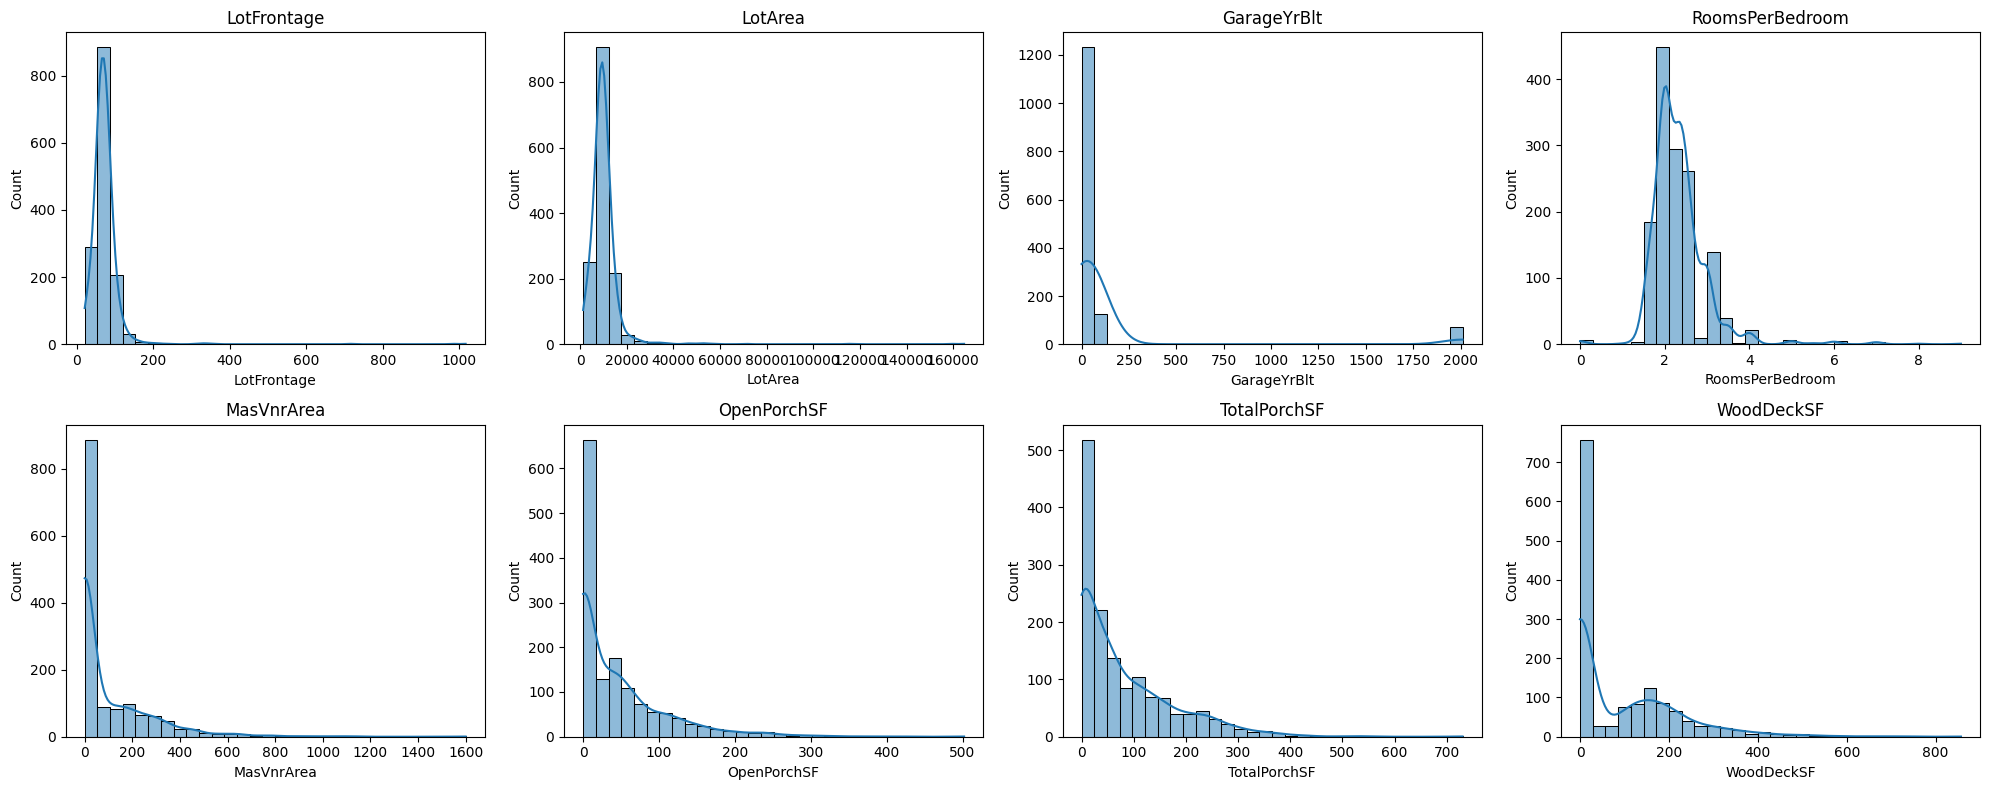

In [117]:
n = len(cols_for_powertransform)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols_for_powertransform):
    sns.histplot(data=new_x_train, x=col, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'{col}')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [118]:
for col in cols_for_powertransform:
    yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
    new_x_train[[col]] = yeo_johnson.fit_transform(new_x_train[[col]])
    new_x_test[[col]] = yeo_johnson.transform(new_x_test[[col]])

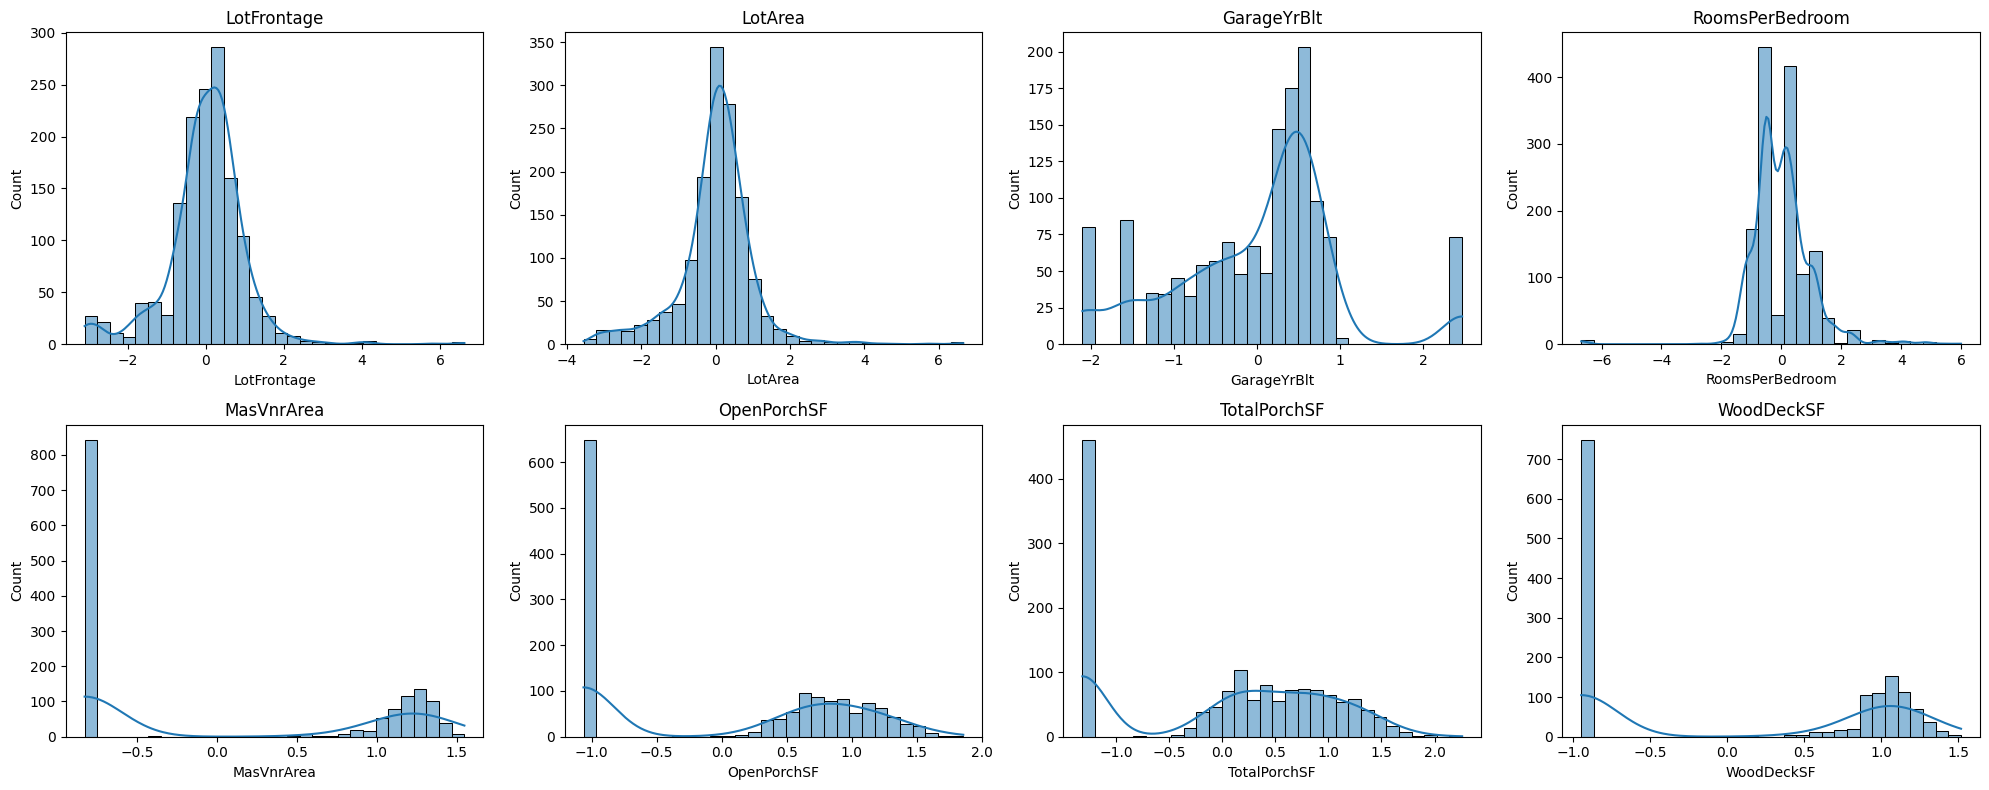

In [119]:
n = len(cols_for_powertransform)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols_for_powertransform):
    sns.histplot(data=new_x_train, x=col, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'{col}')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [120]:
new_skewness = new_x_train[num_cols_to_vizualize].skew().sort_values(ascending=False)
new_skewness

BsmtFinSF2           4.33
ScreenPorch          4.06
EnclosedPorch        2.86
BsmtUnfSF            0.90
1stFlrSF             0.76
2ndFlrSF             0.75
BsmtFinSF1           0.73
GrLivArea            0.65
YearBuilt            0.59
YearRemodAdd         0.49
TotalSF              0.42
LivingAreaPerRoom    0.42
TotalArea            0.42
MasVnrArea           0.40
QualityIndex         0.33
TotalBsmtSF          0.31
GarageArea           0.15
WoodDeckSF           0.14
LotArea              0.08
OpenPorchSF         -0.01
GarageYrBlt         -0.02
RoomsPerBedroom     -0.02
LotFrontage         -0.04
GarageEfficiency    -0.07
TotalPorchSF        -0.22
dtype: float64

#### Robust and standard scaler

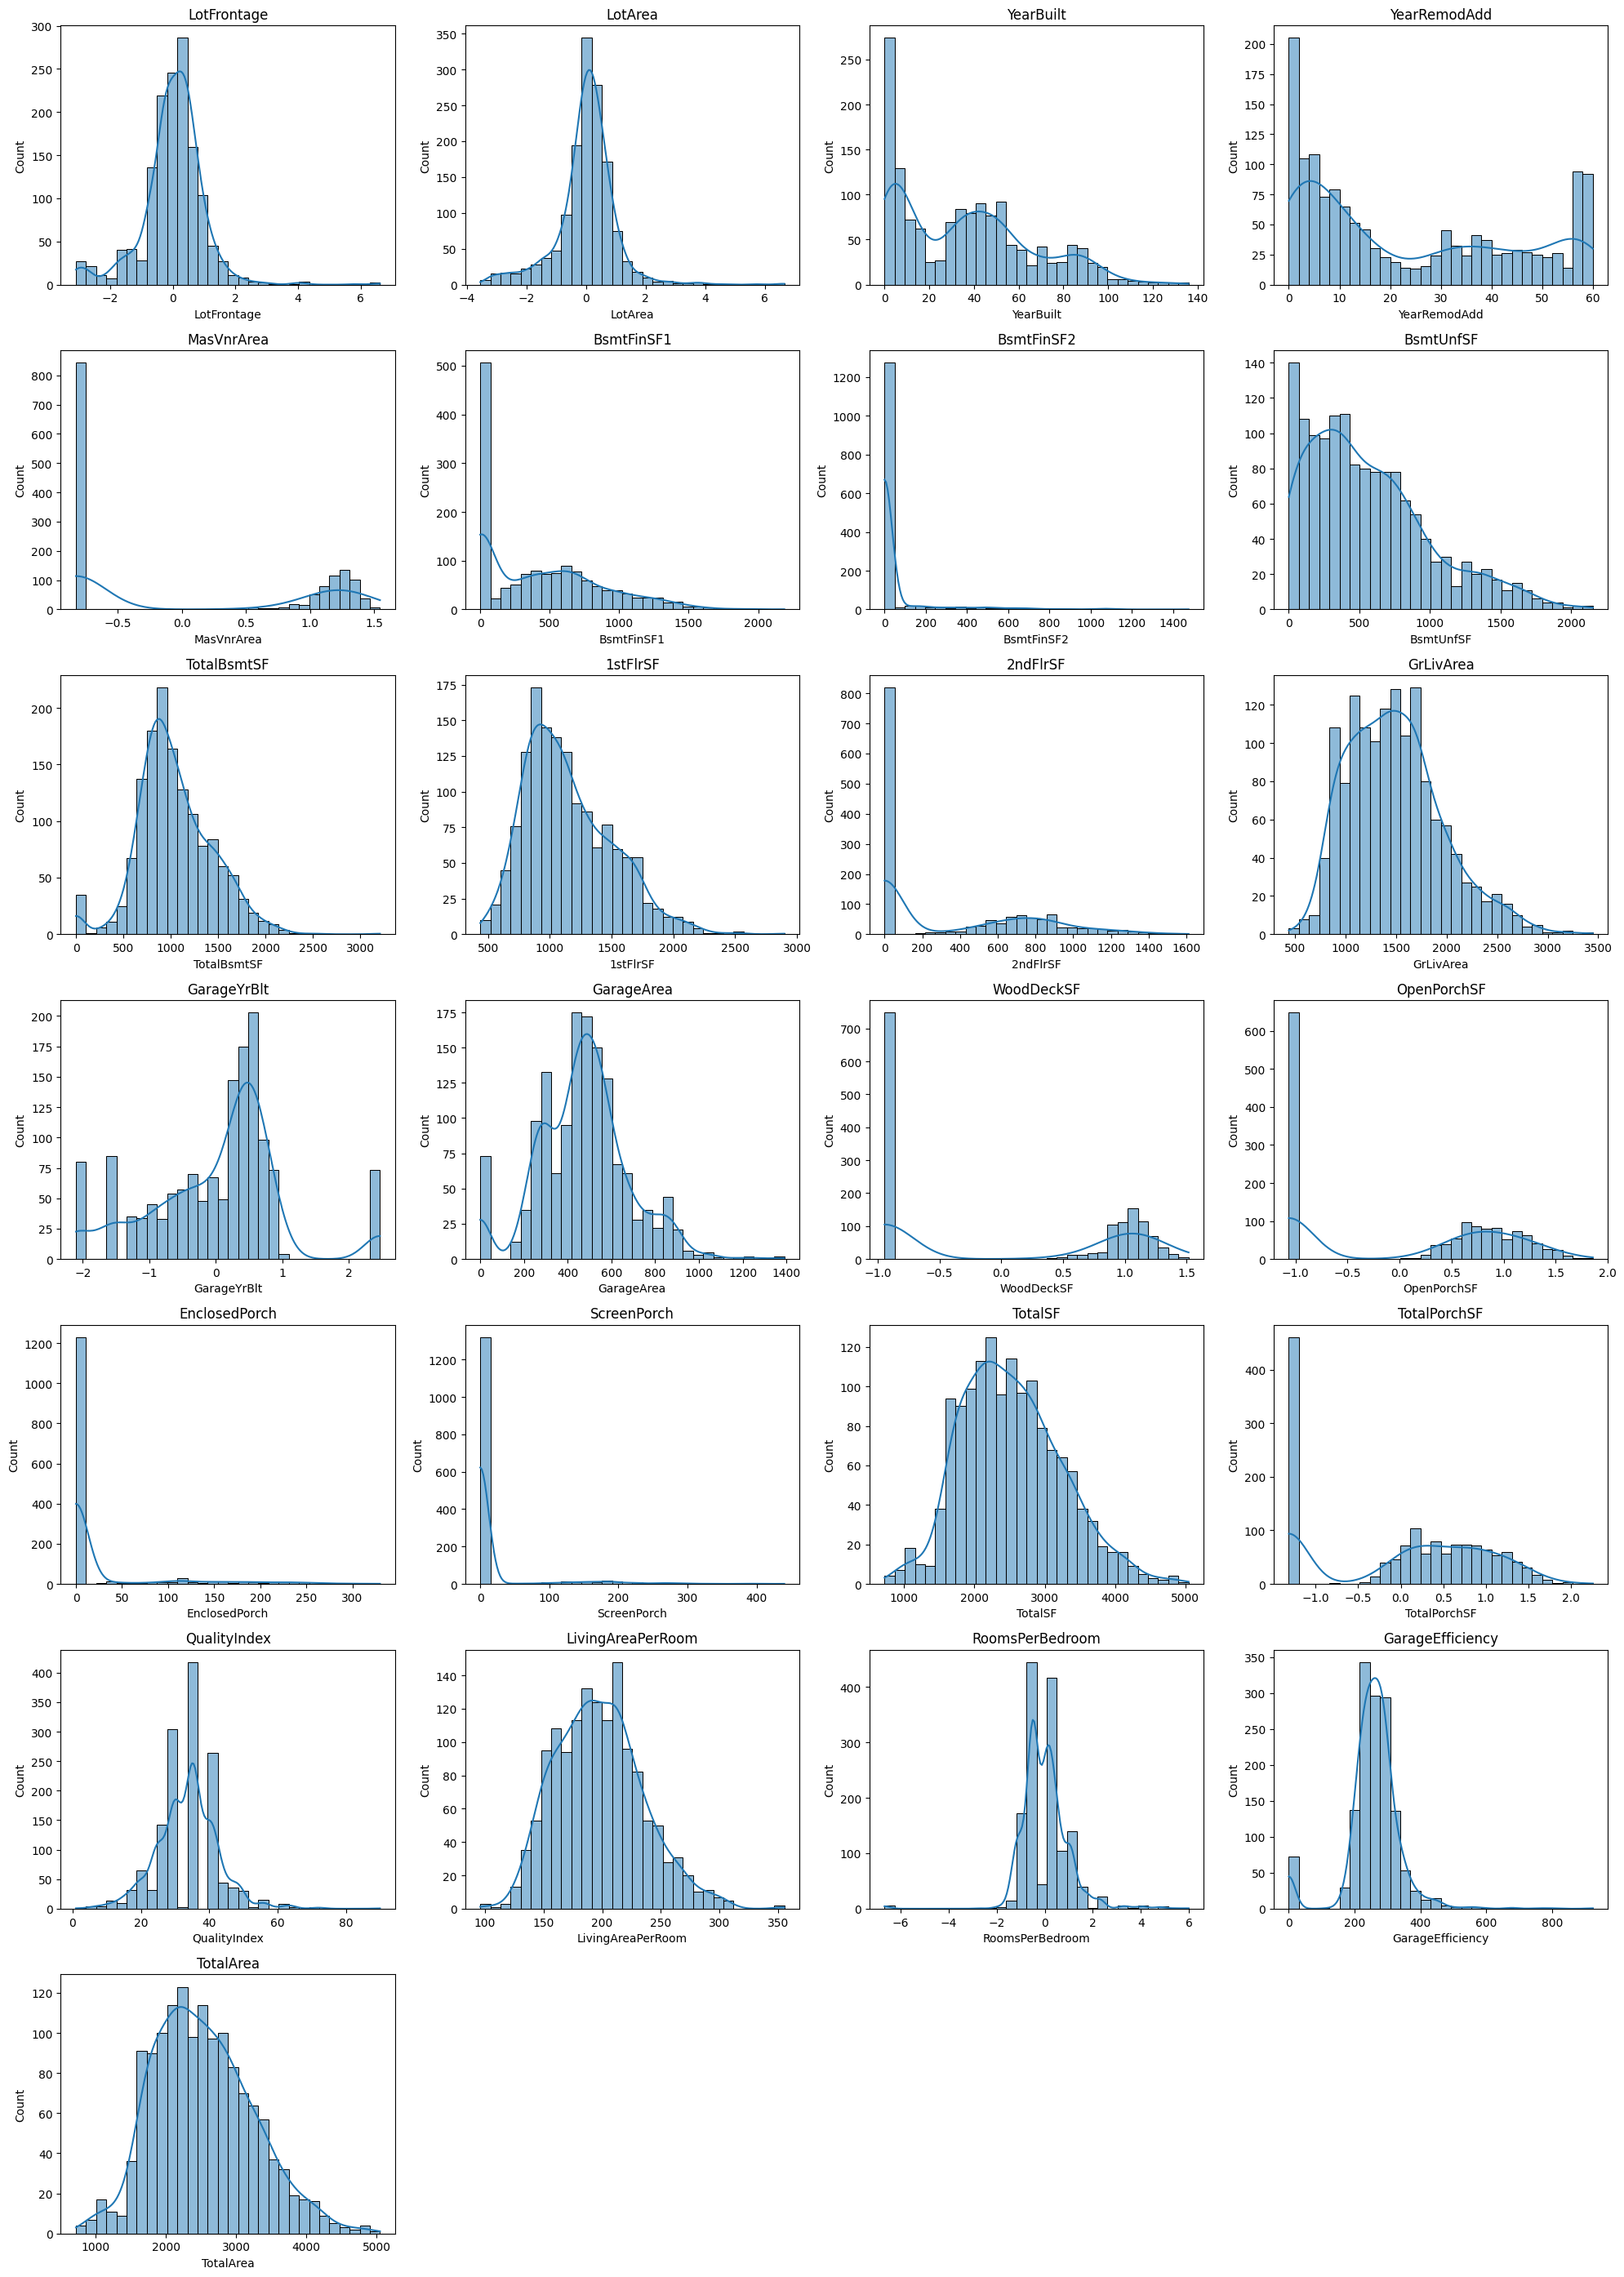

In [121]:
n = len(num_cols_to_vizualize)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols_to_vizualize):
    sns.histplot(data=new_x_train, x=col, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'{col}')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

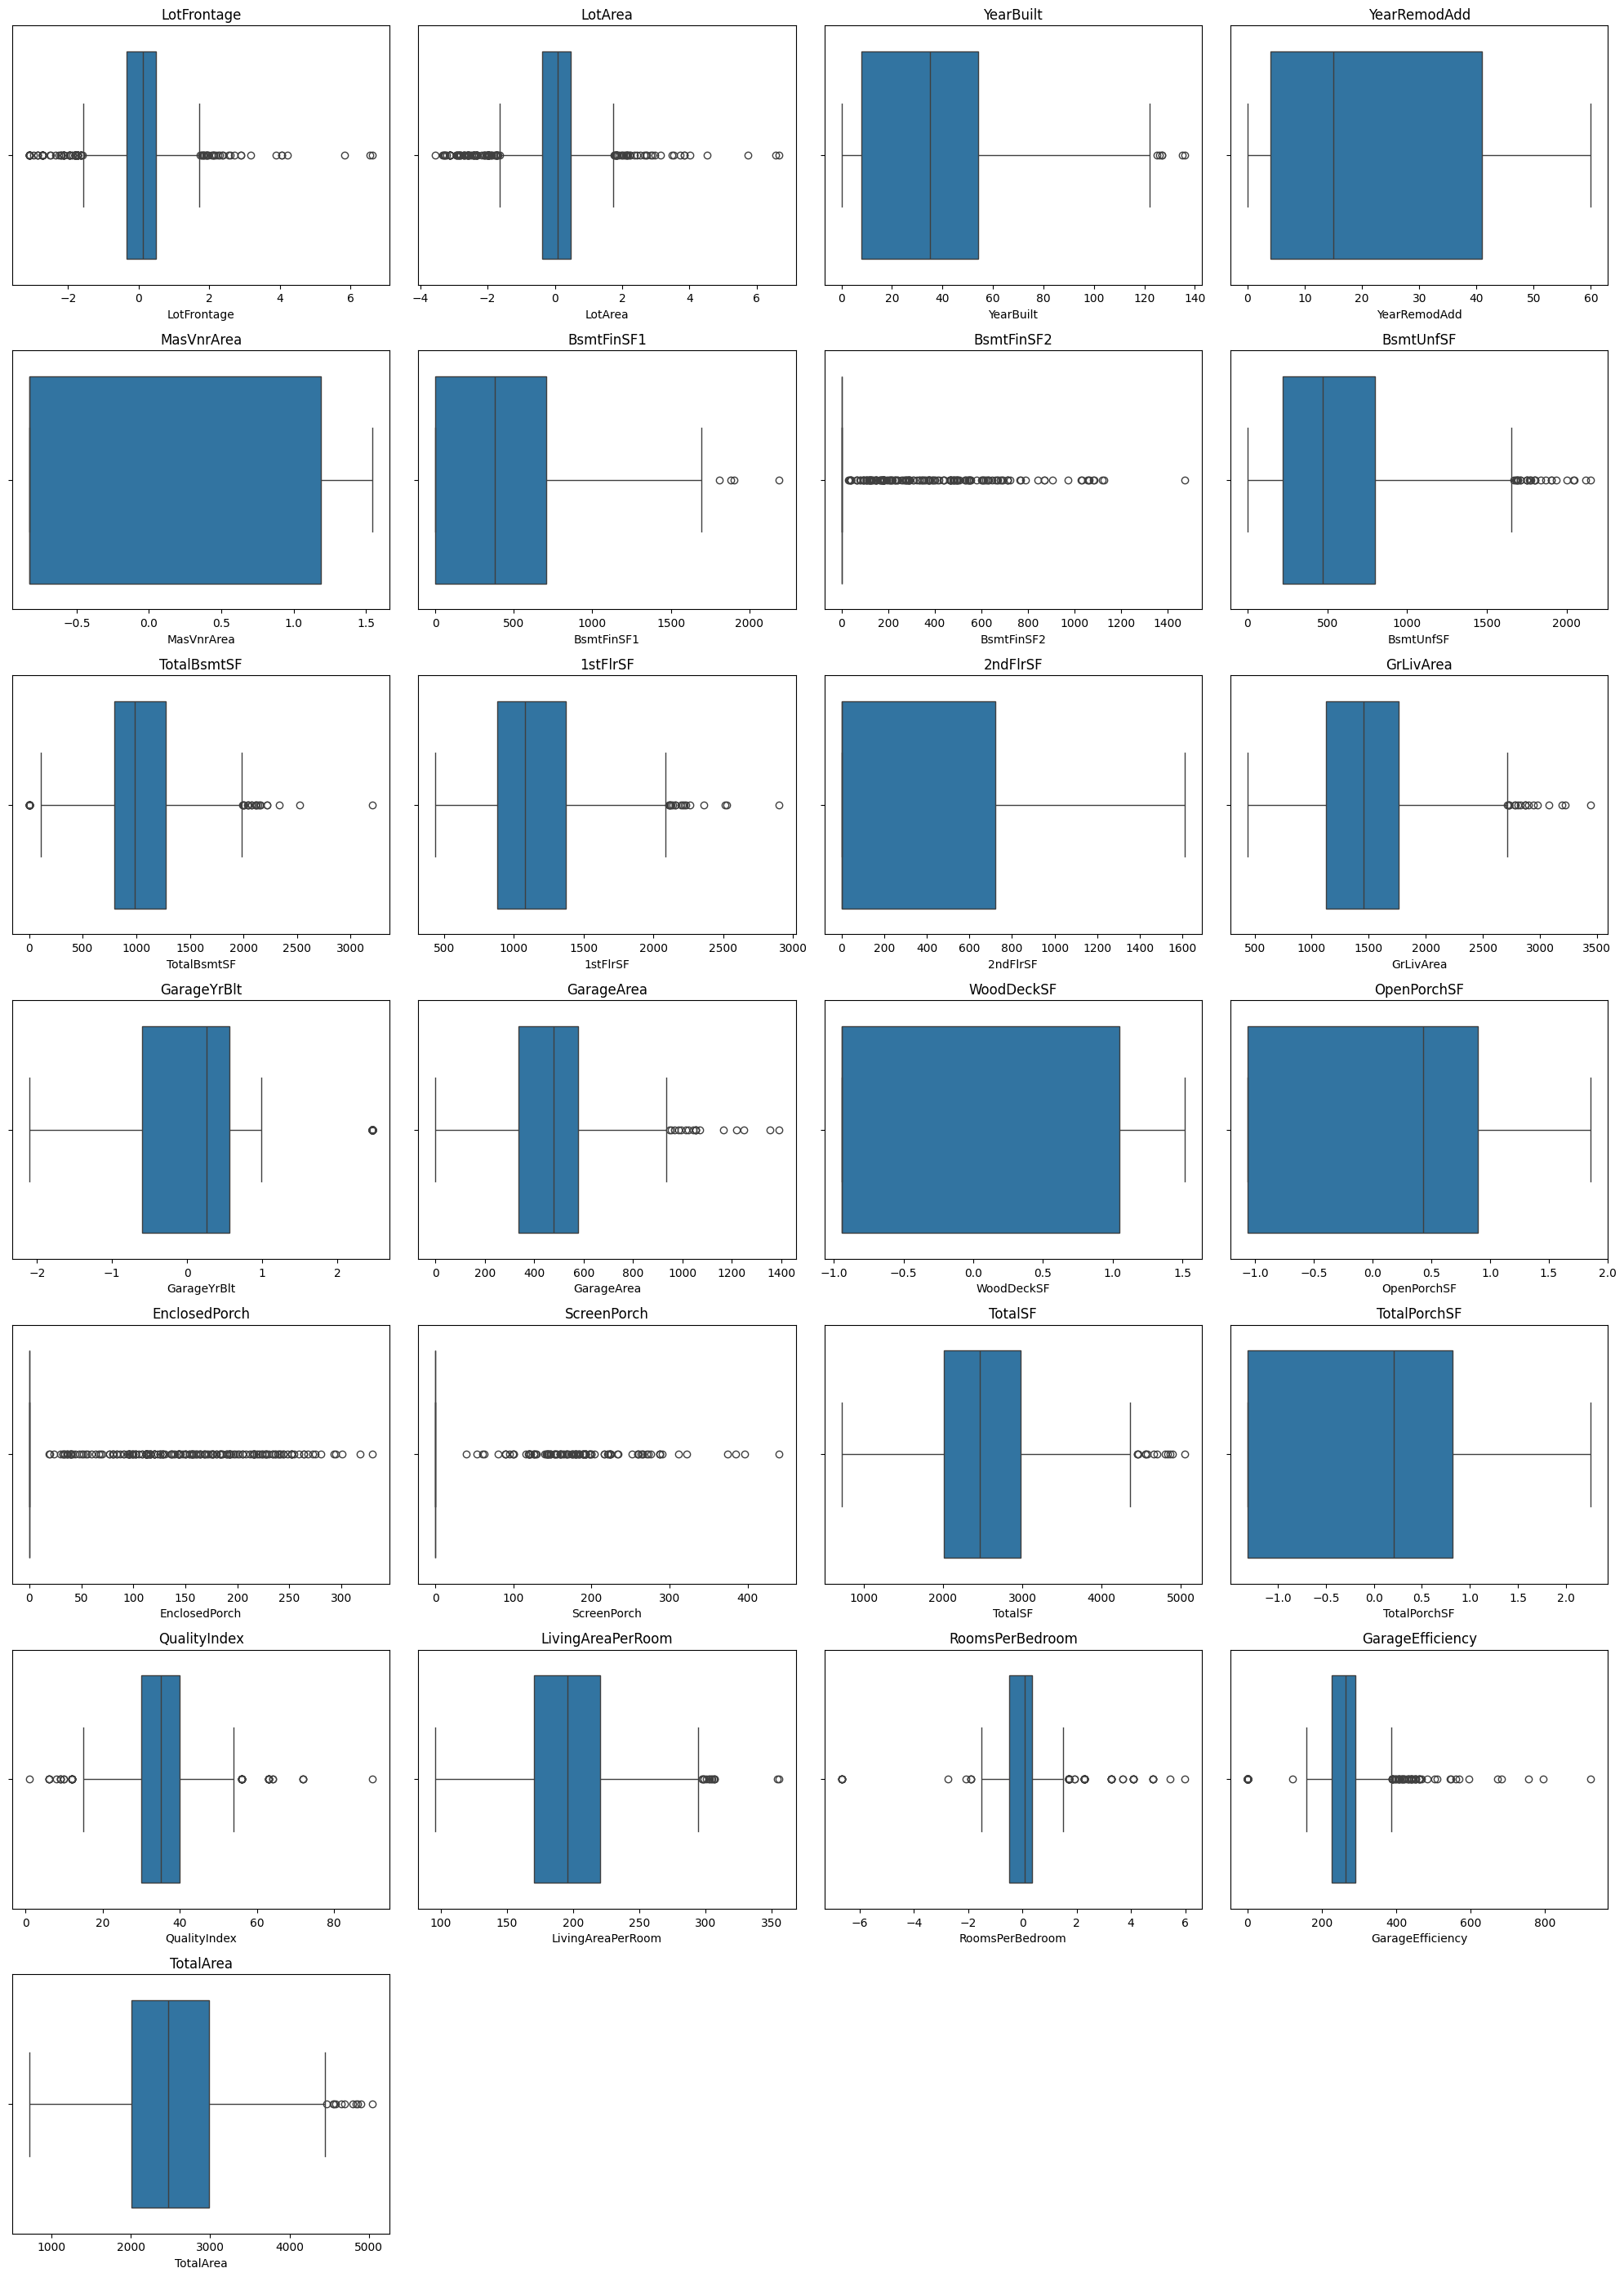

In [122]:
n = len(num_cols_to_vizualize)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols_to_vizualize):
    sns.boxplot(data=new_x_train, x=col, ax=axes[i])
    axes[i].set_title(f'{col}')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [123]:
cols_to_robust = ['YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','2ndFlrSF','GarageYrBlt','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch','TotalPorchSF']
cols_to_standard = ['LotFrontage','LotArea','TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea','TotalSF','QualityIndex','LivingAreaPerRoom','RoomsPerBedroom','GarageEfficiency','TotalArea']

In [124]:
robust = RobustScaler()
robust.fit(new_x_train[cols_to_robust])

new_x_train[cols_to_robust] = robust.transform(new_x_train[cols_to_robust])
new_x_test[cols_to_robust]  = robust.transform(new_x_test[cols_to_robust])

In [125]:
standard = StandardScaler()
standard.fit(new_x_train[cols_to_standard])

new_x_train[cols_to_standard] = standard.transform(new_x_train[cols_to_standard])
new_x_test[cols_to_standard]  = standard.transform(new_x_test[cols_to_standard])

## 4. Multicolinearity

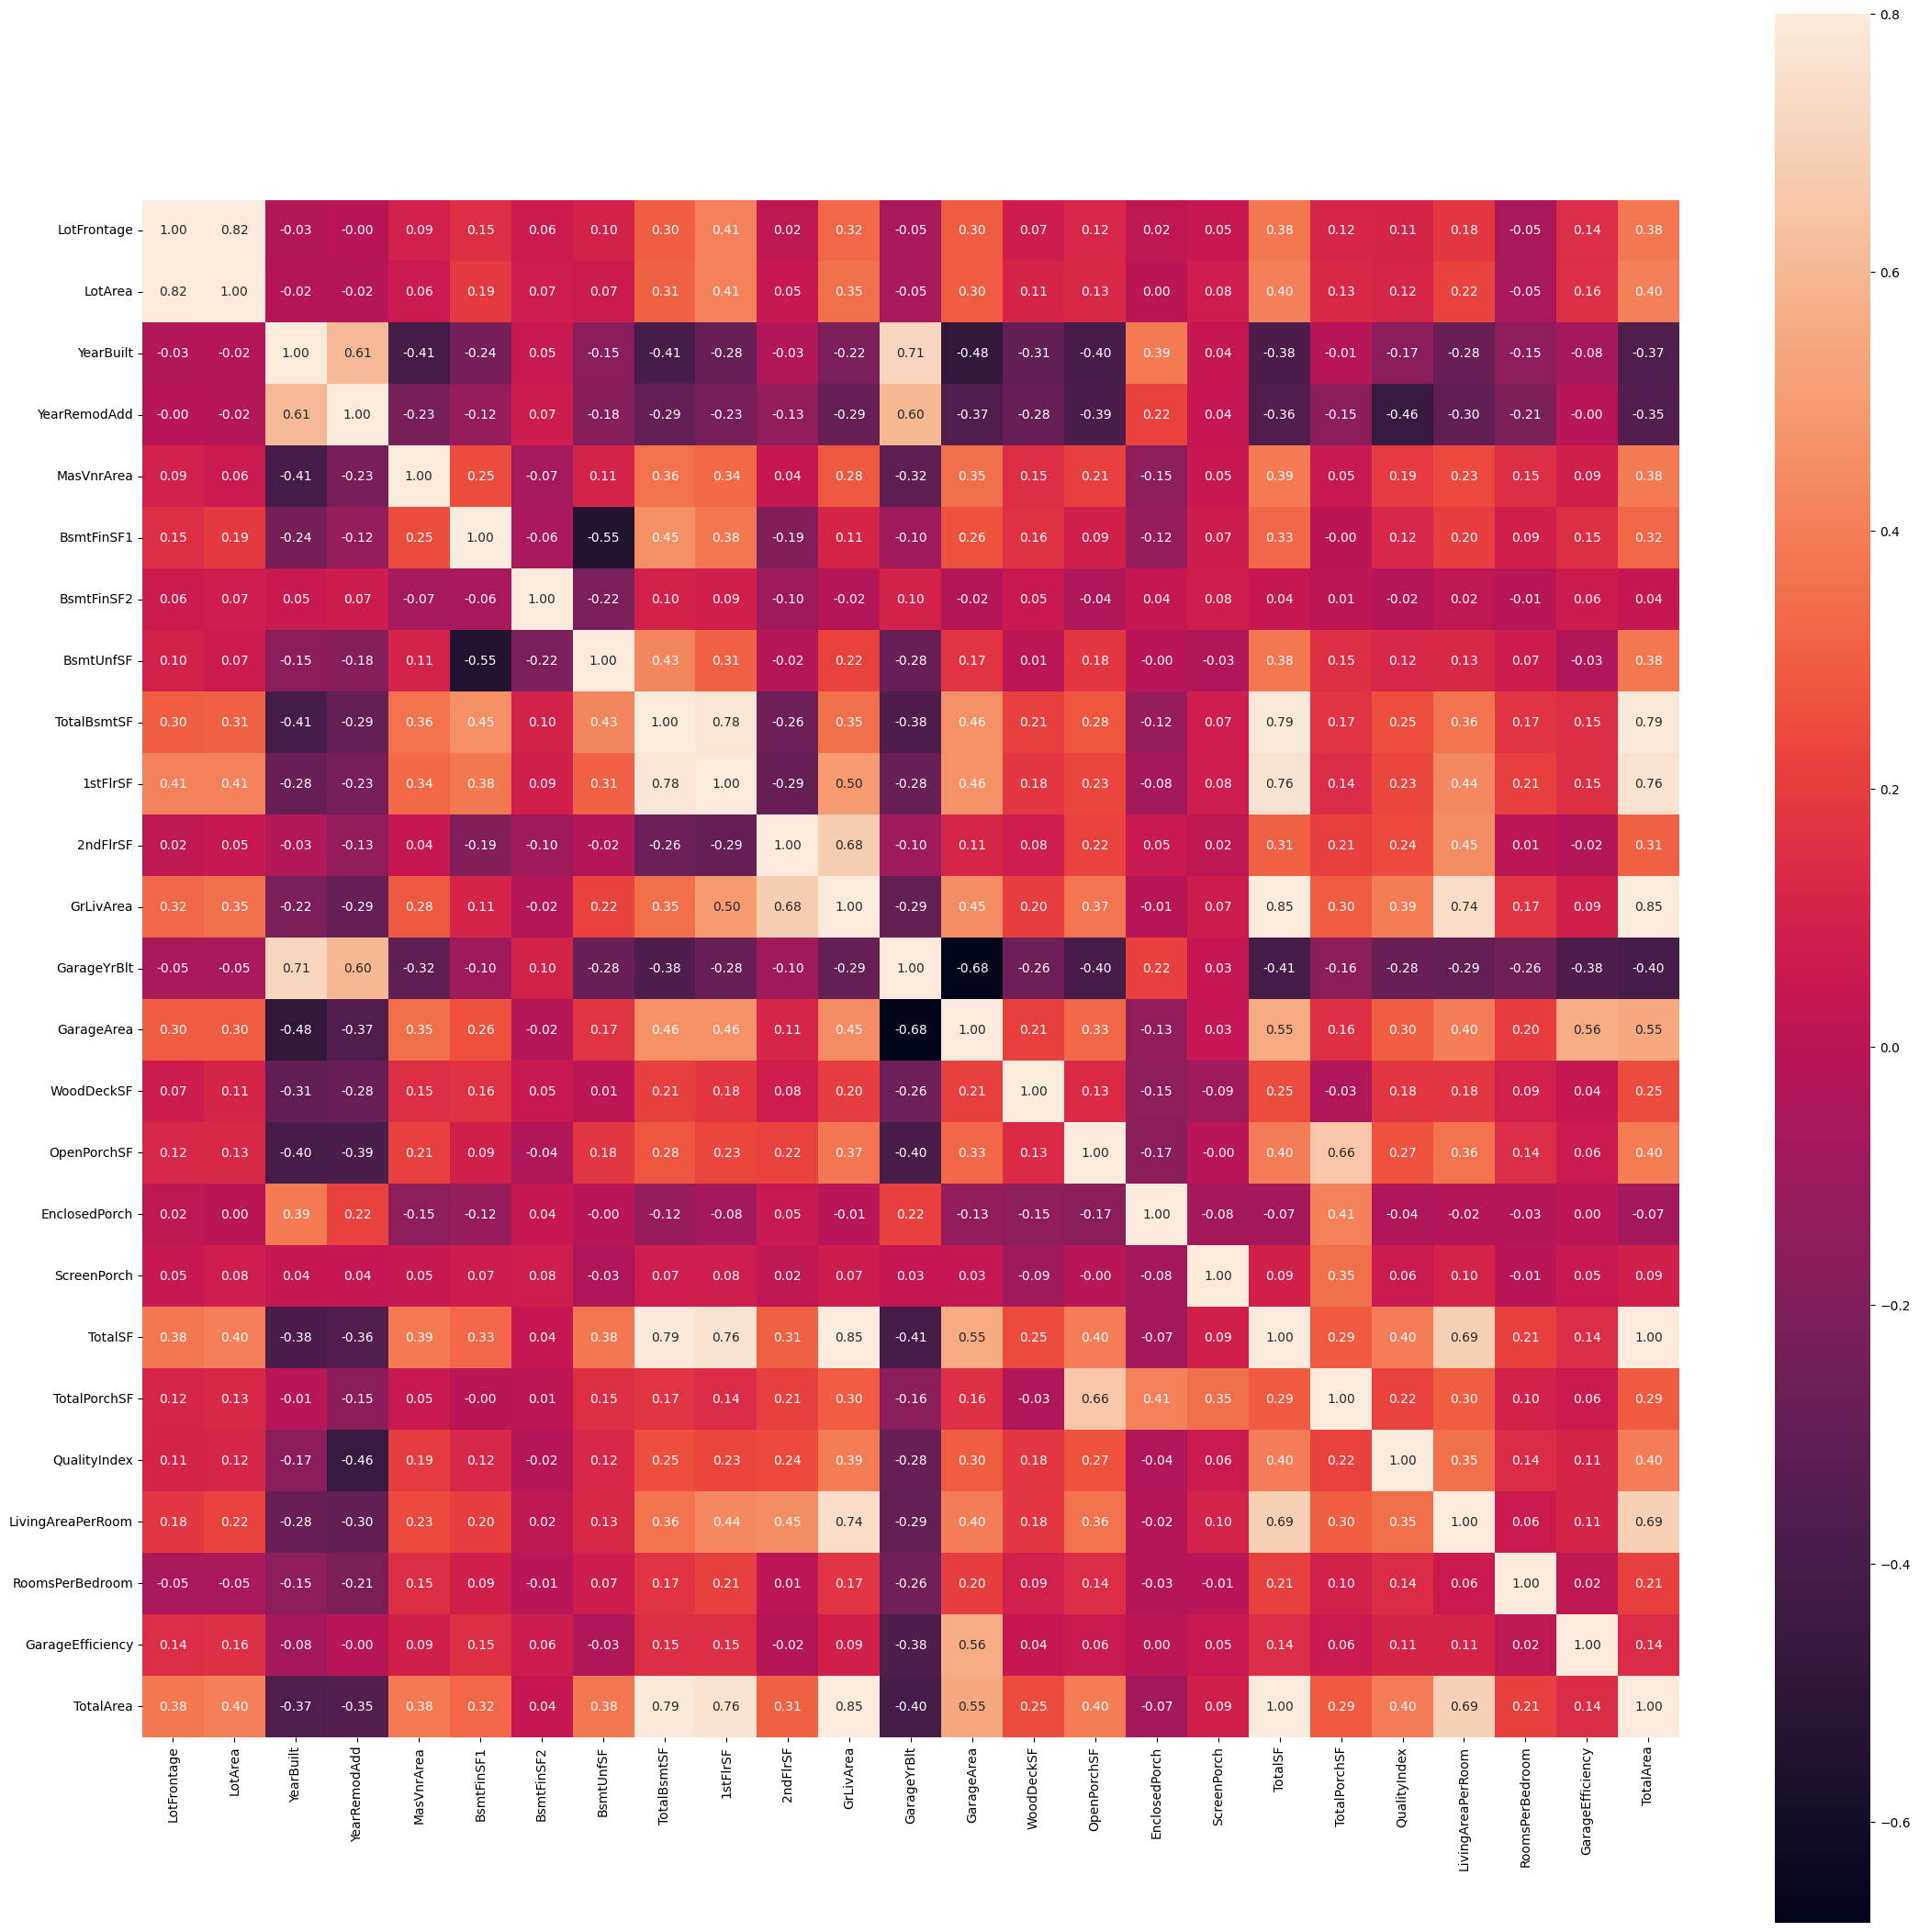

In [126]:
#numerical correlations matrix
full_df = pd.concat([new_x_train,new_y_train], axis=1)
new_corr_matrix = new_x_train.drop(['Id',], axis=1).select_dtypes(include='number').corr()

plt.figure(figsize=(27, 27))
sns.heatmap(new_corr_matrix, vmax=.8, square=True, annot=True, fmt='.2f')
plt.show()

In [127]:
abs_new_corr_matrix = new_corr_matrix.abs()

In [128]:
np.fill_diagonal(abs_new_corr_matrix.values, 0)

In [129]:
threshold = 0.83

high_corr_pairs = [(col1, col2) for col1 in abs_new_corr_matrix.columns 
                   for col2 in abs_new_corr_matrix.columns 
                   if abs_new_corr_matrix.loc[col1, col2] > threshold and col1 < col2]

print("highly correlated pairs:")
for pair in high_corr_pairs:
    print(pair, "->", abs_new_corr_matrix.loc[pair[0], pair[1]])

highly correlated pairs:
('GrLivArea', 'TotalSF') -> 0.8497090721610505
('GrLivArea', 'TotalArea') -> 0.8545185967169046
('TotalArea', 'TotalSF') -> 0.9982736815483815


### PCA

In [130]:
# normalization and finding optimal principal component

multi_cols_1 = new_x_train[['GrLivArea','TotalSF']]   
pca_1  = PCA(n_components=None)
pca_1.fit_transform(multi_cols_1)

multi_cols_2 = new_x_train[['GrLivArea', 'TotalArea']]
pca_2  = PCA(n_components=None)
pca_2.fit_transform(multi_cols_2)

multi_cols_3 = new_x_train[['TotalArea', 'TotalSF']]
pca_3  = PCA(n_components=None)
pca_3.fit_transform(multi_cols_3)

for pca in [pca_1, pca_2, pca_3]:
    print(f'Number of Components : {pca.n_components_}')
    print(f'Ratio every Component / PC : {pca.explained_variance_ratio_}\n')
    print(f'PCA Components : \n{pca.components_}\n')
    print('---------------------------------')

Number of Components : 2
Ratio every Component / PC : [0.92485454 0.07514546]

PCA Components : 
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

---------------------------------
Number of Components : 2
Ratio every Component / PC : [0.9272593 0.0727407]

PCA Components : 
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

---------------------------------
Number of Components : 2
Ratio every Component / PC : [9.99136841e-01 8.63159226e-04]

PCA Components : 
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

---------------------------------


In [131]:
pca_1  = PCA(n_components=1)
multi_cols_1 = pca_1.fit_transform(multi_cols_1)

pca_2  = PCA(n_components=1)
multi_cols_2 = pca_2.fit_transform(multi_cols_2)

pca_3  = PCA(n_components=1)
multi_cols_3 = pca_3.fit_transform(multi_cols_3)


new_x_train['multi_cols_1'] = multi_cols_1.ravel()
new_x_train['multi_cols_2'] = multi_cols_2.ravel()
new_x_train['multi_cols_3'] = multi_cols_3.ravel()


new_x_test['multi_cols_1'] = pca_1.transform(new_x_test[['GrLivArea','TotalSF']]).ravel()
new_x_test['multi_cols_2'] = pca_2.transform(new_x_test[['GrLivArea', 'TotalArea']]).ravel()
new_x_test['multi_cols_3'] = pca_3.transform(new_x_test[['TotalArea', 'TotalSF']]).ravel()


new_x_train.drop(['GrLivArea','TotalSF','TotalArea'], axis=1, inplace=True)
new_x_test.drop(['GrLivArea','TotalSF','TotalArea'], axis=1, inplace=True)

# Model development

In [132]:
final_x_train = new_x_train.copy().drop('Id', axis=1)
final_y_train = new_y_train.copy()

final_x_test = new_x_test.copy()
final_x_train.shape, final_y_train.shape, final_x_test.shape

((1430, 250), (1430,), (1459, 251))

In [133]:
#models to train
lin_reg = LinearRegression()
knn_reg = KNeighborsRegressor()
tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor()
sgd_reg = SGDRegressor()
ridge_reg = Ridge()
lasso_reg = Lasso()
elasticnet_reg = ElasticNet()
linSVR_reg = LinearSVR()
gbr_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor(verbosity=-1)

models_list = {'Linear_Regression':lin_reg,
               'KNeighbors_Regression':knn_reg,
               'Decision_Tree':tree_reg, 
               'Random_Forest':forest_reg, 
               'SGD_Regression':sgd_reg, 
               'Ridge_Regression':ridge_reg,
               'Lasso_Regression':lasso_reg, 
               'ElasticNet_Regression':elasticnet_reg, 
               'LinearSVR':linSVR_reg,
               'GradientBoosting_Regression':gbr_reg, 
               'XGBoost_Regression':xgb_reg, 
               'LightGBM_Regression':lgbm_reg}

In [134]:
#train basic models
def basic_models(df_results,datasetname ,models, cv_method, features_train, target_train):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import cross_val_score
    
    scoring = 'neg_mean_squared_error'
    cv = 10
    df_final = df_results.copy()
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    for key, model in models.items():
        
        if cv_method == 'cross_val_score':
            train_X, test_X, train_y, test_y = train_test_split(features_train, target_train,test_size=0.1 ,random_state=1)
            tm = model.fit(train_X, train_y)
            tm2 = TransformedTargetRegressor(regressor=model,transformer=qt).fit(train_X, train_y)
            tm_predict = tm.predict(test_X)
            prediction = np.sqrt(mean_squared_error(test_y, tm_predict))
            
            model_cv = cross_val_score(model, train_X, train_y,
                                       scoring=scoring, cv=cv)
            score = np.sqrt(-model_cv)
            df_created = pd.DataFrame(
            {'datasetname': datasetname,
             'model': key,
             'cv_method': cv_method,
             'basic_prediction_mean': [prediction],
             'rmse_mean': score.mean(),
             'rmse_std': score.std(),
             'parameters': 'None'})
            
            df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
            
        if cv_method == 'kfold':
            predictions = []
            rmse = []
            kf = KFold(n_splits=10,shuffle=True ,random_state=12)
            for train_index, test_index in kf.split(features_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm2 = TransformedTargetRegressor(regressor=model,transformer=qt).fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                prediction = np.sqrt(mean_squared_error(test_y, tm_predict))
                rmse.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_prediction_mean': [np.min(predictions)],
                 'rmse_mean': np.mean(rmse),
                 'rmse_std': np.std(rmse),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
            
        if cv_method == 'repeatedkfold':
            predictions = []
            rmse = []
            rkf = RepeatedKFold(n_splits=10, random_state=12)
            for train_index, test_index in rkf.split(features_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm2 = TransformedTargetRegressor(regressor=model,transformer=qt).fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                prediction = np.sqrt(mean_squared_error(test_y, tm_predict))
                rmse.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_prediction_mean': [np.min(predictions)],
                 'rmse_mean': np.mean(rmse),
                 'rmse_std': np.std(rmse),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
        
        
        if cv_method == 'shufflesplit':
            predictions = []
            rmse = []
            shs = ShuffleSplit(n_splits=10, test_size=0.25, random_state=12)
            for train_index, test_index in shs.split(features_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm2 = TransformedTargetRegressor(regressor=model,transformer=qt).fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                prediction = np.sqrt(mean_squared_error(test_y, tm_predict))
                rmse.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_prediction_mean': [np.min(predictions)],
                 'rmse_mean': np.mean(rmse),
                 'rmse_std': np.std(rmse),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
        
        
        
        df_row = pd.DataFrame(
            {'datasetname': [df_full_results.loc[0]['datasetname']] ,
             'model': [df_full_results.loc[0]['model']] ,
             'cv_method': [df_full_results.loc[0]['cv_method']],
             'basic_prediction_mean': [df_full_results['basic_prediction_mean'].mean()],
             'rmse_mean': [df_full_results.loc[0]['rmse_mean']],
             'rmse_std': [df_full_results.loc[0]['rmse_std']],
             'parameters': 'None'})
        
        
        df_final = pd.concat([df_final,df_row], axis=0, ignore_index=True)
    return df_final

In [135]:
#dataframe for holding training results
df_results = pd.DataFrame(columns=['datasetname',
                                   'model',
                                   'cv_method',
                                   'basic_prediction_mean',
                                   'rmse_mean',
                                   'rmse_std',
                                   'parameters'])

In [136]:
#evaluation methods
eval_methods = ['cross_val_score',
                'kfold',
                'repeatedkfold',
                'shufflesplit']

In [137]:
#models trainer
def train_models(df_results, dataframes_dict, eval_methods, models_list):

    final_result = []

    for key,value in dataframes_dict.items():
        features_train = value.drop('SalePrice', axis=1)
        target_train = value['SalePrice']
        print(f'training data: {key}')
        for method in eval_methods:
            print(f'training method: {method}')
            result = basic_models(df_results,key, models_list, method, features_train, target_train)
            final_result.append(result)
            print('done method')
        print('done data')

    final_data_of_trained_models = pd.concat(final_result, axis=0)
    return final_data_of_trained_models

In [138]:
dataframes_dict = {'full_df': pd.concat([final_x_train,final_y_train], axis=1)}

In [139]:
df_models_trained = train_models(df_results,dataframes_dict,eval_methods,models_list)

training data: full_df
training method: cross_val_score
done method
training method: kfold
done method
training method: repeatedkfold
done method
training method: shufflesplit
done method
done data


In [140]:
#show the best-performing models to be used later in a stacking regressor.
df_models_trained.sort_values(by='rmse_mean', ascending=True)

datasetname                        model        cv_method  \
5      full_df             Ridge_Regression            kfold   
5      full_df             Ridge_Regression    repeatedkfold   
5      full_df             Ridge_Regression     shufflesplit   
5      full_df             Ridge_Regression  cross_val_score   
0      full_df            Linear_Regression            kfold   
0      full_df            Linear_Regression    repeatedkfold   
9      full_df  GradientBoosting_Regression            kfold   
9      full_df  GradientBoosting_Regression    repeatedkfold   
0      full_df            Linear_Regression     shufflesplit   
0      full_df            Linear_Regression  cross_val_score   
11     full_df          LightGBM_Regression    repeatedkfold   
11     full_df          LightGBM_Regression            kfold   
9      full_df  GradientBoosting_Regression  cross_val_score   
11     full_df          LightGBM_Regression  cross_val_score   
9      full_df  GradientBoosting_Regression     shufflesplit   
11     full_df          LightGBM_Regression     shufflesplit   
3      full_df                Random_Forest    repeatedkfold   
3      full_df                Random_Forest            kfold   
3      full_df                Random_Forest  cross_val_score   
10     full_df           XGBoost_Regression  cross_val_score   
10     full_df           XGBoost_Regression            kfold   
10     full_df           XGBoost_Regression    repeatedkfold   
3      full_df                Random_Forest     shufflesplit   
10     full_df           XGBoost_Regression     shufflesplit   
2      full_df                Decision_Tree    repeatedkfold   
1      full_df        KNeighbors_Regression  cross_val_score   
1      full_df        KNeighbors_Regression            kfold   
1      full_df        KNeighbors_Regression    repeatedkfold   
2      full_df                Decision_Tree            kfold   
2      full_df                Decision_Tree  cross_val_score   
2      full_df                Decision_Tree     shufflesplit   
1      full_df        KNeighbors_Regression     shufflesplit   
8      full_df                    LinearSVR  cross_val_score   
8      full_df                    LinearSVR    repeatedkfold   
8      full_df                    LinearSVR            kfold   
7      full_df        ElasticNet_Regression            kfold   
7      full_df        ElasticNet_Regression    repeatedkfold   
6      full_df             Lasso_Regression            kfold   
6      full_df             Lasso_Regression    repeatedkfold   
7      full_df        ElasticNet_Regression  cross_val_score   
6      full_df             Lasso_Regression  cross_val_score   
7      full_df        ElasticNet_Regression     shufflesplit   
6      full_df             Lasso_Regression     shufflesplit   
8      full_df                    LinearSVR     shufflesplit   
4      full_df               SGD_Regression     shufflesplit   
4      full_df               SGD_Regression    repeatedkfold   
4      full_df               SGD_Regression            kfold   
4      full_df               SGD_Regression  cross_val_score   

    basic_prediction_mean         rmse_mean          rmse_std parameters  
5                    0.10              0.11              0.01       None  
5                    0.09              0.12              0.01       None  
5                    0.10              0.12              0.01       None  
5                    0.10              0.12              0.02       None  
0                    0.10              0.12              0.01       None  
0                    0.09              0.12              0.01       None  
9                    0.10              0.12              0.02       None  
9                    0.09              0.12              0.01       None  
0                    0.10              0.12              0.01       None  
0                    0.11              0.12              0.02       None  
11                   0.09              0.

### Finding best hyperparameters

In [141]:
# X_train, X_valid, y_train, y_valid = train_test_split(final_x_train, final_y_train, test_size=0.2, random_state=12)

# def evaluate_model(model):
#     return cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5).mean()



# def objective_ridge(trial):
#     alpha = trial.suggest_float("alpha", 1e-5, 100.0, log=True)
#     max_iter = trial.suggest_int('max_iter',150, 2000)
#     model = Ridge(alpha=alpha)
#     return evaluate_model(model)



# def objective_lasso(trial):
#     alpha = trial.suggest_float("alpha", 1e-5, 100.0, log=True)
#     model = Lasso(alpha=alpha, max_iter=10000)
#     return evaluate_model(model)



# def objective_linear(trial):
#     model = LinearRegression()
#     return evaluate_model(model)



# def objective_gbm(trial):
#     params = {
#         'n_estimators':trial.suggest_int('n_estimators', 50,2000),
#         'learning_rate':trial.suggest_uniform('learning_rate', 0.001, 1),
#         'max_depth':trial.suggest_int('max_depth', 2, 16),
#         'min_samples_split':trial.suggest_int('min_samples_split', 2, 25),
#         'max_features':trial.suggest_int('max_features', 5, 60)
#     }
#     model = GradientBoostingRegressor(**params)
#     return evaluate_model(model)



# def objective_lgbm(trial):
#     params = {
#         'num_leaves': trial.suggest_int('num_leaves',20,100),
#         'max_depth': trial.suggest_int('max_depth', 2, 15),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.8),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 0.5, 5),
#         'min_child_samples': trial.suggest_int('min_child_samples', 7, 20),
#         'subsample': trial.suggest_uniform('subsample', 0.4, 1),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.02, 15),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.02, 15)
#     }
#     model = LGBMRegressor(**params)
#     return evaluate_model(model)



# def objective_xgb(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),
#         'max_depth': trial.suggest_int('max_depth', 2, 20),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.4, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.35, 1),
#         'gamma': trial.suggest_float('gamma', 0.1, 1),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 15),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 15)
#     }
#     model = XGBRegressor(**params, verbosity=0)
#     return evaluate_model(model)

# def objective_catboost(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#         'max_bin': trial.suggest_int('max_bin', 10, 500),
#         'eval_metric': 'RMSE', 
#         "verbose": 0
#     }

#     model = CatBoostRegressor(**params)
#     return evaluate_model(model)



# def run_optimization(objective_fn, n_trials=50):
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective_fn, n_trials=n_trials, show_progress_bar=False)
#     print("Najlepszy wynik:", study.best_value)
#     print("Najlepsze parametry:", study.best_params)


# print("Ridge params:")
# run_optimization(objective_ridge)

# print("\nLasso params:")
# run_optimization(objective_lasso)

# print("\nLinearRegression params:")
# run_optimization(objective_linear)

# print("\nGradientBoosting params:")
# run_optimization(objective_gbm)

# print("\nLightGBM params:")
# run_optimization(objective_lgbm)

# print("\nXGBoost params:")
# run_optimization(objective_xgb)

# print("\nCatBoost params:")
# run_optimization(objective_catboost)

In [142]:
ridge_best_params = {'alpha': 20.163343892910696, 'max_iter': 1089}
lasso_best_params = {'alpha': 0.0005544606673495207}
gbr_best_params = {'n_estimators': 1511, 'learning_rate': 0.013185886510434404, 'max_depth': 3, 'min_samples_split': 7, 'max_features': 31}
lgbm_best_params = {'num_leaves': 27, 'max_depth': 15, 'learning_rate': 0.08144499540927219, 'n_estimators': 114, 'min_child_weight': 0, 'min_child_samples': 20, 'subsample': 0.41224208521813865, 'reg_alpha': 0.14041975682587537, 'reg_lambda': 11.624462990665489}
xgb_best_params = {'n_estimators': 316, 'learning_rate': 0.3835809314191706, 'max_depth': 2, 'min_child_weight': 5.897774841986006, 'subsample': 0.8273294374546626, 'gamma': 0.13705849051055988, 'reg_alpha': 0.5880163649331536, 'reg_lambda': 3.796866539620683}
cat_best_params = {'iterations': 315, 'learning_rate': 0.04467455805023316, 'depth': 4, 'l2_leaf_reg': 0.22349550128945053, 'subsample': 0.547339992448185, 'colsample_bylevel': 0.5981466400121912, 'min_data_in_leaf': 79, 'max_bin': 405}

ridge_model = Ridge(random_state=12, **ridge_best_params)
ridge_model.fit(final_x_train, final_y_train)

lasso_model = Lasso(random_state=12, **lasso_best_params)
lasso_model.fit(final_x_train, final_y_train)

gbr_model = GradientBoostingRegressor(random_state=12, **gbr_best_params)
gbr_model.fit(final_x_train, final_y_train)

linear_model = LinearRegression(fit_intercept=True, positive=False)
linear_model.fit(final_x_train, final_y_train)

lgbm_model = LGBMRegressor(verbosity=-1, random_state=12, **lgbm_best_params)
lgbm_model.fit(final_x_train, final_y_train)

xgb_model = XGBRegressor(random_state=12, **xgb_best_params)
xgb_model.fit(final_x_train, final_y_train)

cat_model = CatBoostRegressor(verbose=0,random_state=12, **cat_best_params)
cat_model.fit(final_x_train, final_y_train)

### Create Stacking Regressor

In [143]:
cv_fold = KFold(n_splits= 10, shuffle=True, random_state=12)

model = StackingRegressor(
    estimators=[
        ('Ridge', ridge_model),
        ('Lasso', lasso_model),           
        ('LinearRegression', linear_model),       
        ('GradientBoostingRegressor', gbr_model),
        ('xgb', xgb_model),
        ('lightgbm', lgbm_model),
        ('catboost', cat_model)
    ],  
        final_estimator = RidgeCV(),
        cv=cv_fold
)

model.fit(final_x_train,final_y_train)

StackingRegressor(cv=KFold(n_splits=10, random_state=12, shuffle=True),
                  estimators=[('Ridge',
                               Ridge(alpha=20.163343892910696, max_iter=1089,
                                     random_state=12)),
                              ('Lasso',
                               Lasso(alpha=0.0005544606673495207,
                                     random_state=12)),
                              ('LinearRegression', LinearRegression()),
                              ('GradientBoostingRegressor',
                               GradientBoostingRegressor(learning_rate=0.013185886510434404,
                                                         max_fe...
                                            random_state=12, ...)),
                              ('lightgbm',
                               LGBMRegressor(learning_rate=0.08144499540927219,
                                             max_depth=15, min_child_weight=0,
                                             n_estimators=114, num_leaves=27,
                                             random_state=12,
                                             reg_alpha=0.14041975682587537,
                                             reg_lambda=11.624462990665489,
                                             subsample=0.41224208521813865,
                                             verbosity=-1)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x73e40f800ad0>)],
                  final_estimator=RidgeCV())

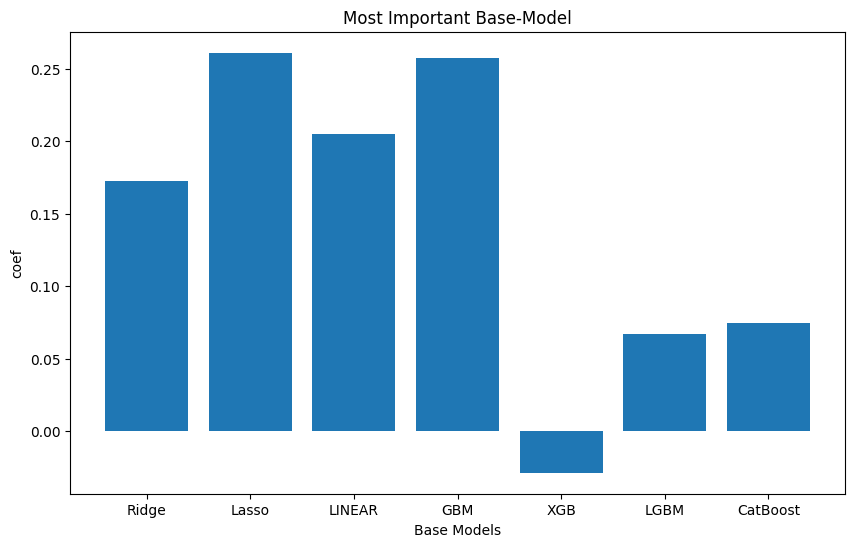

In [144]:
#visualize which model has the biggest contribution for meta-model
base_models = [ 'Ridge', 'Lasso','LINEAR' ,'GBM','XGB','LGBM', 'CatBoost']

meta_model = model.final_estimator_ 
coefficients = meta_model.coef_   

plt.figure(figsize=(10,6))
plt.bar(base_models, coefficients)
plt.xlabel('Base Models')
plt.ylabel('coef')
plt.title('Most Important Base-Model')
plt.show()

### Create predictions

In [145]:
predictions = model.predict(final_x_test.drop('Id',axis=1))

In [146]:
output = pd.DataFrame({'Id': df_test.Id,
                     'SalePrice': np.expm1(predictions)})
#output.to_csv('./housing_predictions.csv', index=False)